# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Check your Colab region**  
   First, determine the region where your Colab instance is running. For best performance (faster data transfers), we recommend using a runtime located in the **US** or **Europe**.  
   - If your runtime is elsewhere, stop it and create a new one until it’s in one of the preferred regions.

In [ ]:
!pip install ipinfo==5.1.1 > /dev/null 2>&1
import ipinfo; info = ipinfo.getHandler().getDetails(); print(f"{info.city} ({info.country_name})")

2. **Clone the `dlfb` library**  
   Next, clone the repository that contains the `dlfb` library.

In [ ]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

3. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [ ]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,localization,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

4. **Authenticate with Google**  
   You’ll then need to authenticate with your Google account so the notebook can access and download the necessary datasets for this chapter.

In [ ]:
from google.colab import auth

auth.authenticate_user()
# NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter localization

5. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [ ]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

# 6. Learning Spatial Organization Patterns Within Cells


## 6.1. Biology Primer
### 6.1.1. Spatial Organization within the Cell
### 6.1.2. Protein Localization
### 6.1.3. Understanding Protein Localization


## 6.2. Machine Learning Primer
### 6.2.1. Autoencoders
### 6.2.2. Variational Autoencoders
#### 6.2.2.1. Why add randomness?
#### 6.2.2.2. Continuous Latent Space
### 6.2.3. Vector-Quantized Variational Autoencoders (VQ-VAEs)
#### 6.2.3.1. Where Does the Codebook Come From?
#### 6.2.3.2. How Large Should the Codebook Be?
### 6.2.4. Dissecting a VQ-VAE Diagram
### 6.2.5. Training a VQ-VAE


## 6.3. Constructing the Dataset
### 6.3.1. Data Requirements
### 6.3.2. Sourcing the Data
### 6.3.3. Getting a Glimpse of the Dataset


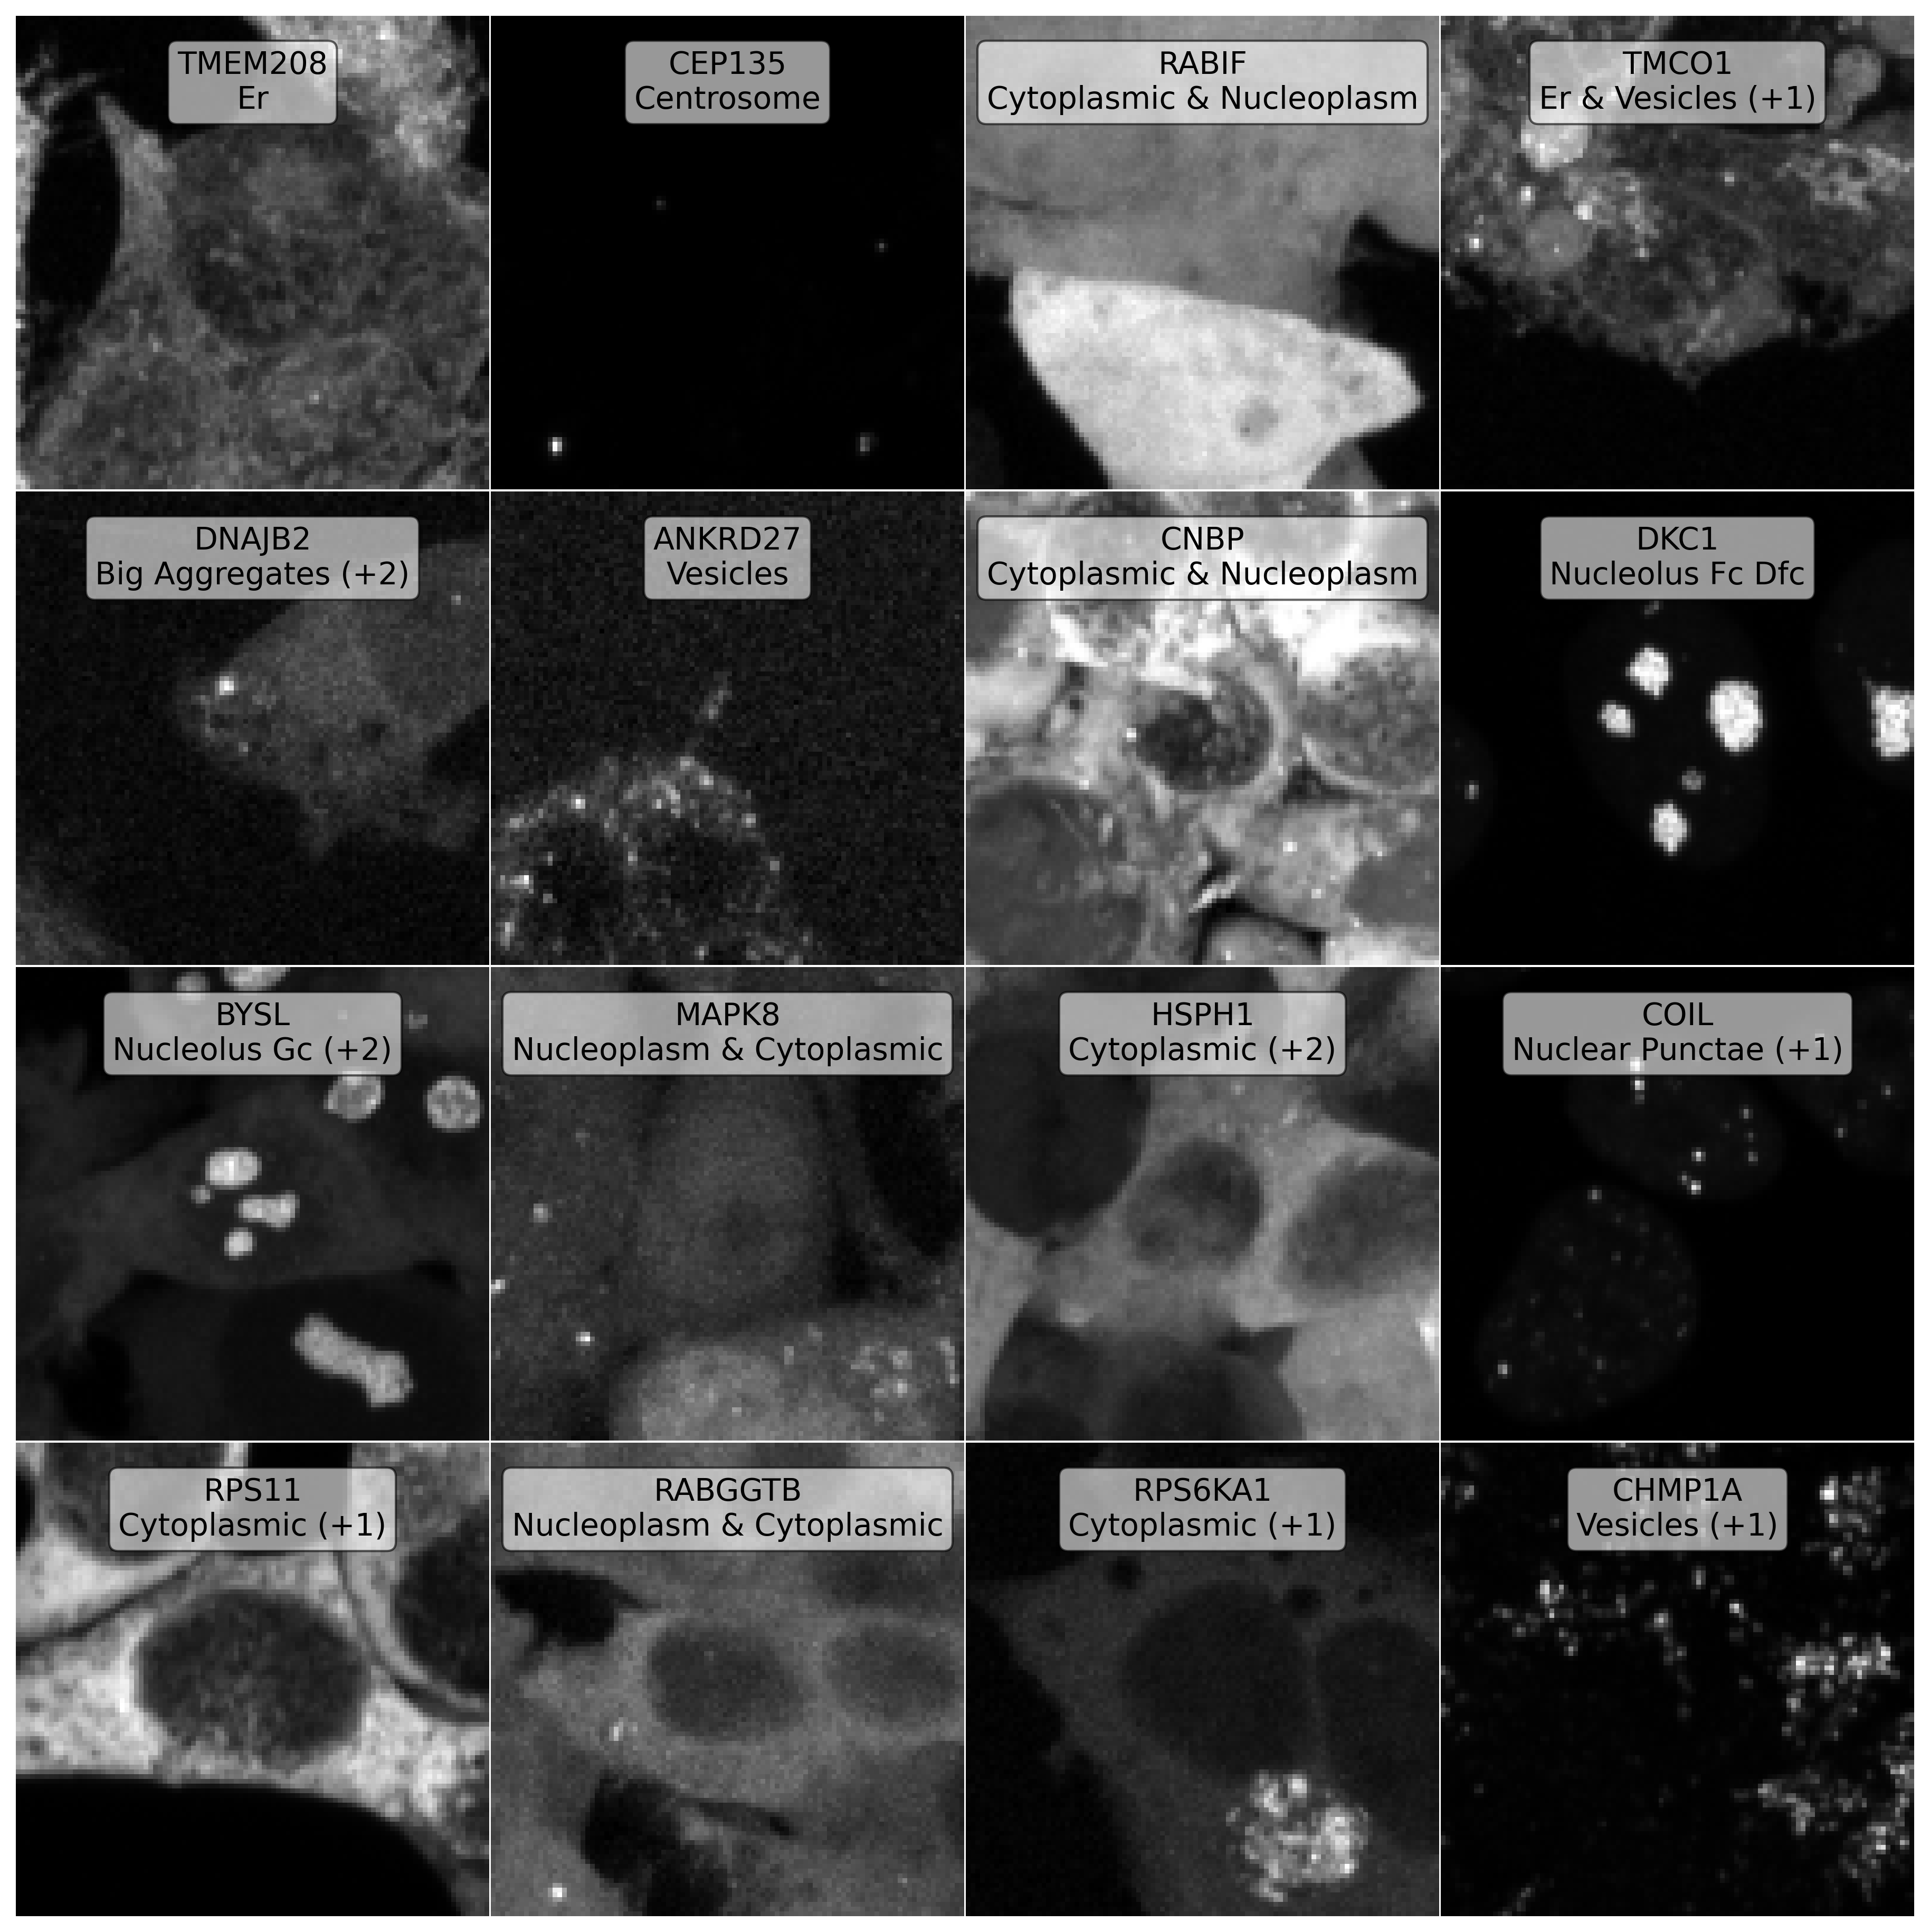

In [3]:
import jax

from dlfb.localization.dataset.utils import get_dataset
from dlfb.utils.context import assets

rng = jax.random.PRNGKey(42)
rng, rng_frames = jax.random.split(rng, 2)

dataset = get_dataset(data_path=assets("localization/datasets"))
n_frames = 16
dataset.plot_random_frames(n=n_frames, rng=rng_frames);

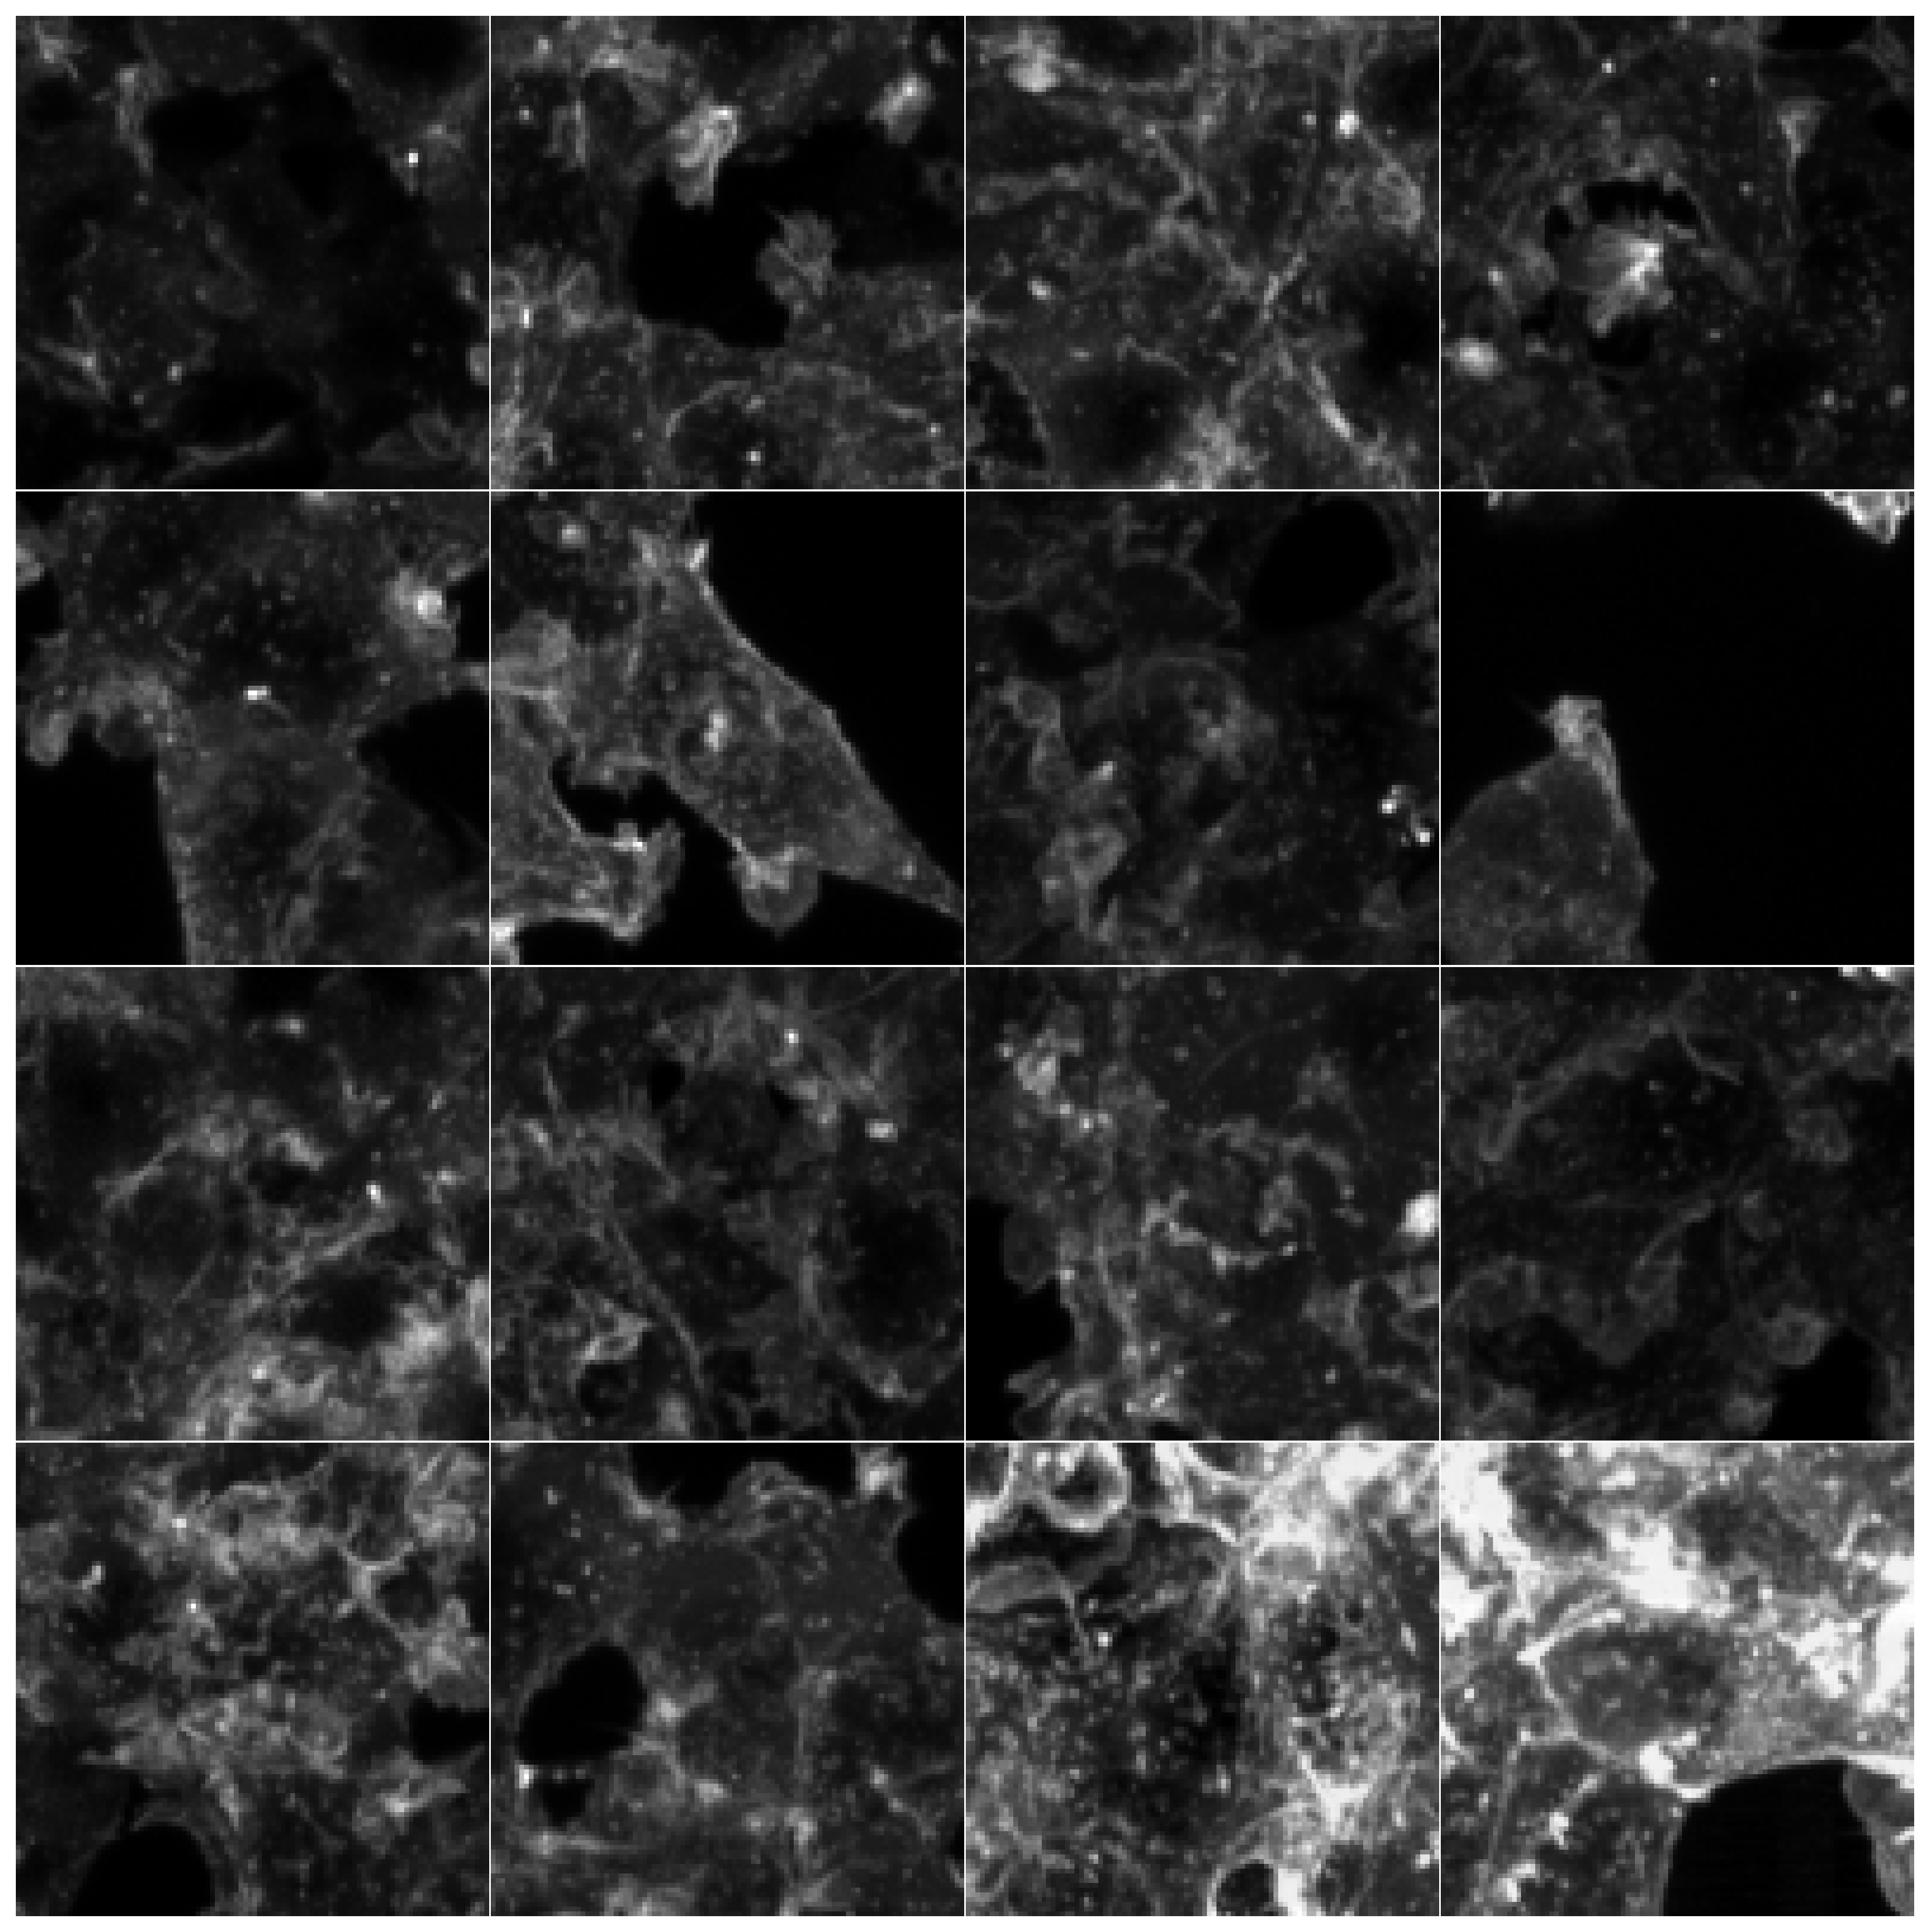

In [4]:
selected_protein = "ACTB"
dataset.plot_random_frames(
  n=n_frames, with_labels=False, rng=rng_frames, gene_symbols=[selected_protein]
);

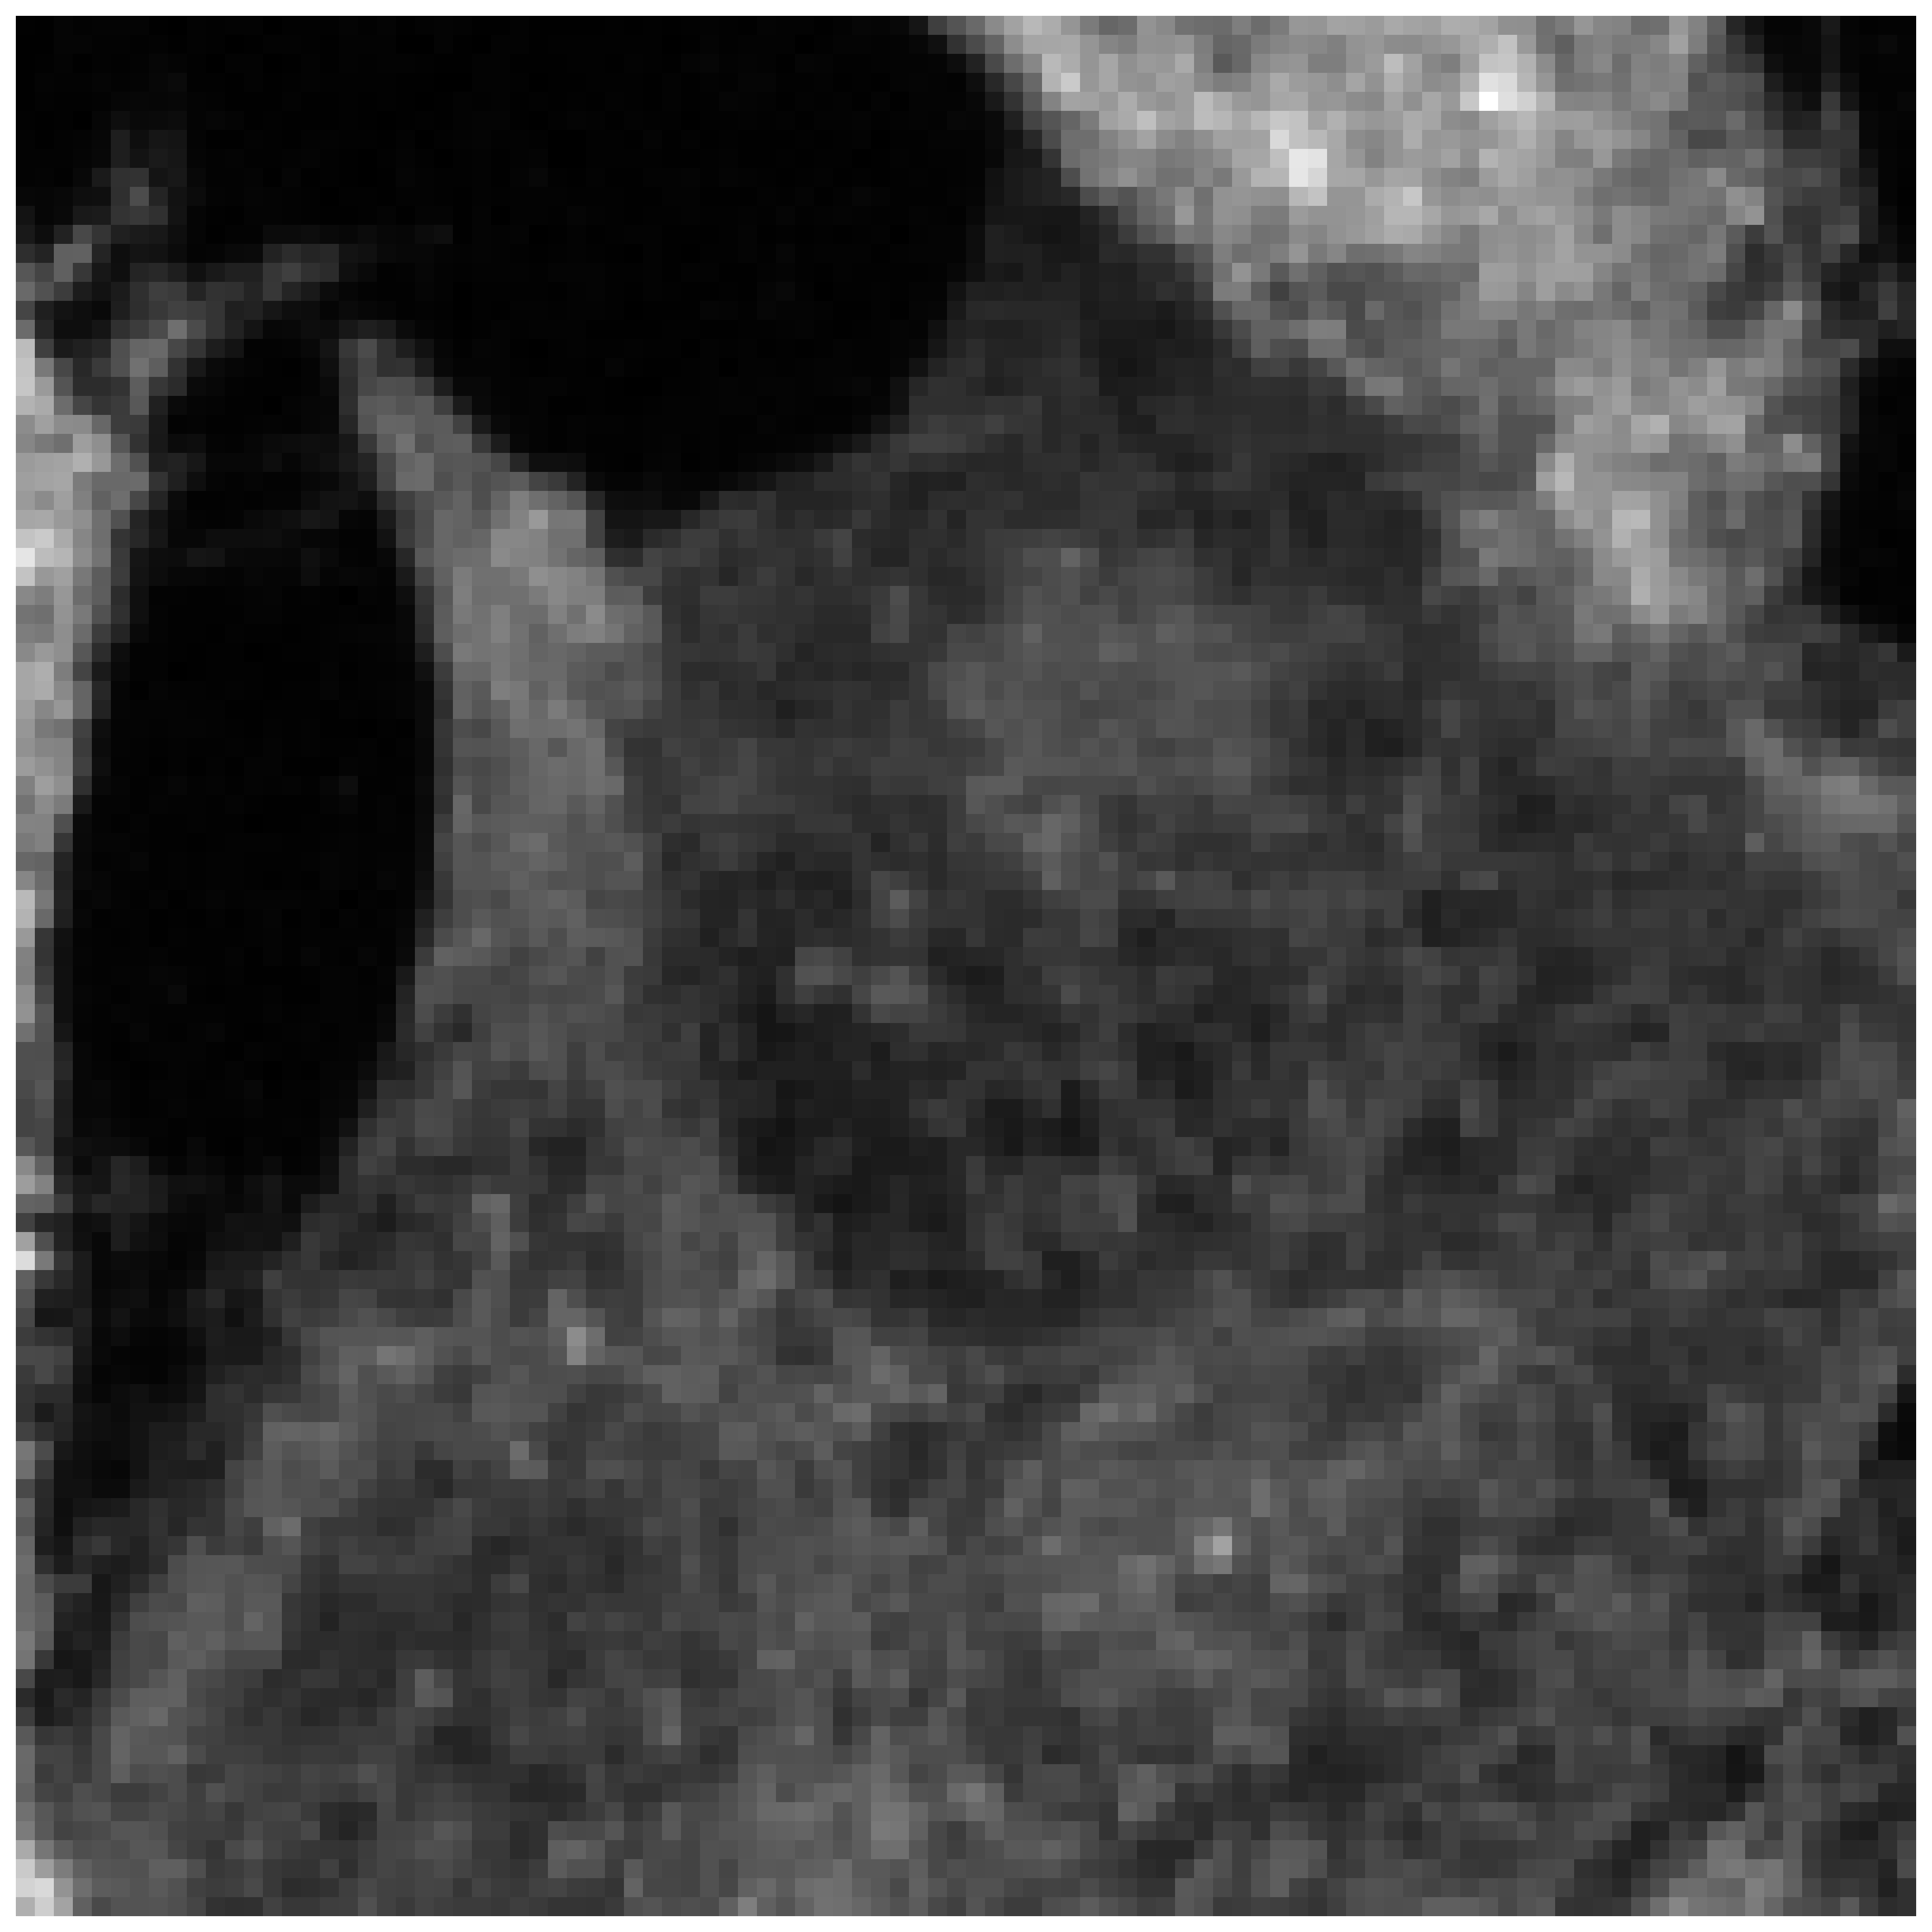

In [6]:
dataset.plot_random_frames(n=1, with_labels=False, rng=rng_frames);

### 6.3.4. Implementing a DatasetBuilder Class


In [7]:
from dlfb.localization.dataset.builder import DatasetBuilder

display([DatasetBuilder])

class DatasetBuilder:
  """Builds a dataset with splits for learning."""

  def __init__(self, data_path: str, force_recreate: bool = False):
    self.images = ImageLoader(data_path).load(force_recreate=force_recreate)
    self.labels = LabelLoader(data_path).load(force_recreate=force_recreate)

  def build(
    self,
    rng: jax.Array,
    splits: dict[str, float],
    exclusive_by: str = "fov_id",
    n_proteins: int | None = None,
    max_frames: int | None = None,
  ) -> dict[str, Dataset]:
    """Retrieve a dataset of proteins split into learning sets."""
    validate_splits(splits)

    if not n_proteins:
      n_proteins = self.labels.get_n_proteins()

    # Sample frames from chosen proteins.
    rng, rng_proteins = jax.random.split(rng, num=2)
    frames = self.labels.get_frames_of_random_proteins(rng_proteins, n_proteins)

    n_frames = frames.shape[0]
    if max_frames is not None and n_frames > max_frames:
      # Limit number of frames used.
      frames = frames.head(max_frames)
      n_frames = max_frames

    # Get random entities to exclusively be assigned across splits
    rng, rng_perm = jax.random.split(rng, 2)
    set_ids = jnp.array(frames[exclusive_by].to_numpy(np.int32))
    shuffled_set_ids = jax.random.permutation(rng_perm, jnp.unique(set_ids))

    # Assign consecutive ids to proteins across all frames
    frame_ids = jnp.array(frames["frame_id"].to_numpy(np.int32))
    lookup_with_protein_encoding = self._encode_proteins_across_frames(
      self.labels.lookup.iloc[frame_ids.tolist()]
    )

    # Assemble the dataset by splits considering exclusive sets
    dataset_splits, start = {}, 0
    for name, size in self._get_split_sizes(
      splits, n_sets=len(shuffled_set_ids)
    ):
      mask = jnp.isin(set_ids, shuffled_set_ids[start : (start + size)])
      dataset_splits[name] = Dataset(
        images=self.images,
        labels=Labels(
          lookup=lookup_with_protein_encoding.loc[
            frame_ids[mask].tolist()
          ].reset_index(drop=True)
        ),
      )
      start += size

    return dataset_splits

  def _get_split_sizes(self, splits, n_sets):
    """Convert split fractional sizes to absolute counts."""
    names = list(splits.keys())
    sizes = [int(n_sets * splits[name]) for name in names[:-1]]
    sizes.append(n_sets - sum(sizes))  # Ensure total adds up
    for name, size in zip(names, sizes):
      yield name, size

  def _encode_proteins_across_frames(self, lookup) -> pd.DataFrame:
    """Encode protein labels across dataset to consecutive integers."""
    protein_ids_in_frames = lookup["protein_id"].to_list()
    unique_protein_ids = sorted(set(protein_ids_in_frames))
    mapping = pd.DataFrame(
      [
        {"protein_id": id_, "code": idx}
        for idx, id_ in enumerate(unique_protein_ids)
      ]
    )
    return lookup.merge(mapping, how="left", on="protein_id").set_index(
      "frame_id", drop=False
    )

#### 6.3.4.1. Building a First Dataset Instance


In [ ]:
from dlfb.localization.dataset import Dataset
from dlfb.utils.context import assets

builder = DatasetBuilder(data_path=assets("localization/datasets"))

rng, rng_dataset = jax.random.split(rng, 2)
dataset: dict[str, Dataset] = builder.build(
  rng=jax.random.PRNGKey(42),
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  exclusive_by="fov_id",
  n_proteins=50,
)

#### 6.3.4.2. Accessing the Dataset Internals


## 6.4. Building a Prototype Model
### 6.4.1. Defining the LocalizationModel


In [2]:
from dlfb.localization.model import LocalizationModel

display([LocalizationModel])

class LocalizationModel(nn.Module):
  """VQ-VAE model with a fully connected output head."""

  embedding_dim: int
  num_embeddings: int
  commitment_cost: float
  num_classes: int | None
  dropout_rate: float
  classification_head_layers: int

  def setup(self):
    """Builds the encoder, decoder, quantizer, and output head."""
    self.encoder = Encoder(latent_dim=self.embedding_dim)
    self.vector_quantizer = VectorQuantizer(
      num_embeddings=self.num_embeddings,
      embedding_dim=self.embedding_dim,
      commitment_cost=self.commitment_cost,
    )
    self.decoder = Decoder(latent_dim=self.embedding_dim)
    self.classification_head = ClassificationHead(
      num_classes=self.num_classes,
      dropout_rate=self.dropout_rate,
      layers=self.classification_head_layers,
    )

  def __call__(self, x: jax.Array, is_training: bool):
    """Runs a forward pass."""
    ze = self.encoder(x)
    zq, perplexity, codebook_loss, commitment_loss = self.vector_quantizer(ze)
    decoded = self.decoder(zq)
    logits = self.classification_head(
      zq.reshape((zq.shape[0], -1)), is_training
    )
    return decoded, perplexity, codebook_loss, commitment_loss, logits

  def create_train_state(
    self, rng: jax.Array, dummy_input: jax.Array, tx
  ) -> TrainState:
    """Initializes training state."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, dummy_input, is_training=False)
    return TrainState.create(
      apply_fn=self.apply, params=variables["params"], tx=tx, key=rng_dropout
    )

  def get_encoding_indices(self, x: jax.Array) -> jax.Array:
    """Returns nearest codebook indices for input."""
    ze = self.encoder(x)
    encoding_indices = self.vector_quantizer.get_closest_codebook_indices(ze)
    return encoding_indices

### 6.4.2. The Encoder: Processing Input Images


In [3]:
from dlfb.localization.model import Encoder, ResnetBlock

display([Encoder, ResnetBlock])

class Encoder(nn.Module):
  """Convolutional encoder producing latent feature maps."""

  latent_dim: int

  def setup(self):
    """Initializes convolutional and residual layers."""
    self.conv1 = nn.Conv(
      self.latent_dim // 2, kernel_size=(4, 4), strides=(2, 2), padding=1
    )
    self.conv2 = nn.Conv(
      self.latent_dim, kernel_size=(4, 4), strides=(2, 2), padding=1
    )
    self.conv3 = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )
    self.res_block1 = ResnetBlock(self.latent_dim)
    self.res_block2 = ResnetBlock(self.latent_dim)

  def __call__(self, x):
    """Forward pass applying convolution and residual blocks to input."""
    x = self.conv1(x)
    x = nn.relu(x)
    x = self.conv2(x)
    x = nn.relu(x)
    x = self.conv3(x)
    x = self.res_block1(x)
    x = self.res_block2(x)
    return x


class ResnetBlock(nn.Module):
  """Residual convolutional block with GroupNorm and Swish activation."""

  latent_dim: int

  def setup(self):
    """Initializes normalization and convolutional layers."""
    self.norm1 = nn.GroupNorm()
    self.conv1 = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )
    self.norm2 = nn.GroupNorm()
    self.conv2 = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )

  def __call__(self, x):
    """Applies two conv layers with Swish activation and skip connection."""
    h = nn.swish(self.norm1(x))
    h = self.conv1(h)
    h = nn.swish(self.norm2(h))
    h = self.conv2(h)
    return x + h

### 6.4.3. The VectorQuantizer: Discretizing the Embeddings


In [4]:
from dlfb.localization.model import VectorQuantizer

display([VectorQuantizer])

class VectorQuantizer(nn.Module):
  """Vector quantization module for VQ-VAE."""

  num_embeddings: int
  embedding_dim: int
  commitment_cost: float

  def setup(self):
    """Initializes the codebook as trainable parameters."""
    self.codebook = self.param(
      "codebook",
      nn.initializers.lecun_uniform(),
      (self.embedding_dim, self.num_embeddings),
    )

  def __call__(self, inputs: jax.Array):
    """Applies quantization and returns outputs with losses and perplexity."""
    quantized, encoding_indices = self.quantize(inputs)
    codebook_loss, commitment_loss = self.compute_losses(inputs, quantized)
    perplexity = self.calculate_perplexity(encoding_indices)
    ste = self.get_straight_through_estimator(quantized, inputs)
    return ste, perplexity, codebook_loss, commitment_loss

  def quantize(self, inputs: jax.Array):
    """Snaps inputs to nearest codebook entries."""
    encoding_indices = self.get_closest_codebook_indices(inputs)
    flat_quantized = jnp.take(self.codebook, encoding_indices, axis=1).swapaxes(
      1, 0
    )
    quantized = jnp.reshape(flat_quantized, inputs.shape)
    return quantized, encoding_indices

  def get_closest_codebook_indices(self, inputs: jax.Array) -> jax.Array:
    """Returns indices of closest codebook vectors."""
    distances = self.calculate_distances(inputs)
    return jnp.argmin(distances, 1)

  def calculate_distances(self, inputs: jax.Array) -> jax.Array:
    """Computes Euclidean distances between inputs and codebook vectors."""
    flat_inputs = jnp.reshape(inputs, (-1, self.embedding_dim))
    distances = (
      jnp.sum(jnp.square(flat_inputs), 1, keepdims=True)
      - 2 * jnp.matmul(flat_inputs, self.codebook)
      + jnp.sum(jnp.square(self.codebook), 0, keepdims=True)
    )
    return distances

  def compute_losses(self, inputs: jax.Array, quantized: jax.Array):
    """Computes codebook and commitment losses."""
    codebook_loss = jnp.mean(jnp.square(quantized - lax.stop_gradient(inputs)))
    commitment_loss = self.commitment_cost * jnp.mean(
      jnp.square(lax.stop_gradient(quantized) - inputs)
    )
    return codebook_loss, commitment_loss

  def calculate_perplexity(self, encoding_indices: jax.Array) -> jax.Array:
    """Computes codebook usage perplexity."""
    encodings = jax.nn.one_hot(
      encoding_indices,
      self.num_embeddings,
    )
    avg_probs = jnp.mean(encodings, 0)
    perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))
    return perplexity

  @staticmethod
  def get_straight_through_estimator(
    quantized: jax.Array, inputs: jax.Array
  ) -> jax.Array:
    """Applies straight-through estimator to pass gradients through
    quantization.
    """

    ste = inputs + lax.stop_gradient(quantized - inputs)
    return ste

In [5]:
display([VectorQuantizer.__call__])

def __call__(self, inputs: jax.Array):
    """Applies quantization and returns outputs with losses and perplexity."""
    quantized, encoding_indices = self.quantize(inputs)
    codebook_loss, commitment_loss = self.compute_losses(inputs, quantized)
    perplexity = self.calculate_perplexity(encoding_indices)
    ste = self.get_straight_through_estimator(quantized, inputs)
    return ste, perplexity, codebook_loss, commitment_loss

In [6]:
display([VectorQuantizer.quantize, VectorQuantizer.calculate_distances])

def quantize(self, inputs: jax.Array):
    """Snaps inputs to nearest codebook entries."""
    encoding_indices = self.get_closest_codebook_indices(inputs)
    flat_quantized = jnp.take(self.codebook, encoding_indices, axis=1).swapaxes(
      1, 0
    )
    quantized = jnp.reshape(flat_quantized, inputs.shape)
    return quantized, encoding_indices


  def calculate_distances(self, inputs: jax.Array) -> jax.Array:
    """Computes Euclidean distances between inputs and codebook vectors."""
    flat_inputs = jnp.reshape(inputs, (-1, self.embedding_dim))
    distances = (
      jnp.sum(jnp.square(flat_inputs), 1, keepdims=True)
      - 2 * jnp.matmul(flat_inputs, self.codebook)
      + jnp.sum(jnp.square(self.codebook), 0, keepdims=True)
    )
    return distances

#### 6.4.3.1. Calculating VQ-VAE–Specific Losses


In [7]:
display([VectorQuantizer.compute_losses])

def compute_losses(self, inputs: jax.Array, quantized: jax.Array):
    """Computes codebook and commitment losses."""
    codebook_loss = jnp.mean(jnp.square(quantized - lax.stop_gradient(inputs)))
    commitment_loss = self.commitment_cost * jnp.mean(
      jnp.square(lax.stop_gradient(quantized) - inputs)
    )
    return codebook_loss, commitment_loss

#### 6.4.3.2. Using Perplexity to Measure Codebook Use


In [8]:
display([VectorQuantizer.calculate_perplexity])

def calculate_perplexity(self, encoding_indices: jax.Array) -> jax.Array:
    """Computes codebook usage perplexity."""
    encodings = jax.nn.one_hot(
      encoding_indices,
      self.num_embeddings,
    )
    avg_probs = jnp.mean(encodings, 0)
    perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))
    return perplexity

#### 6.4.3.3. Using the Straight-Through Estimator


In [9]:
display([VectorQuantizer.get_straight_through_estimator])

@staticmethod
  def get_straight_through_estimator(
    quantized: jax.Array, inputs: jax.Array
  ) -> jax.Array:
    """Applies straight-through estimator to pass gradients through
    quantization.
    """

    ste = inputs + lax.stop_gradient(quantized - inputs)
    return ste

### 6.4.4. Decoder: Decoding the Discretized Embeddings Back to Images


In [10]:
from dlfb.localization.model import Decoder, Upsample

display([Decoder, Upsample])

class Decoder(nn.Module):
  """Decoder module for reconstructing input from quantized representations."""

  latent_dim: int

  def setup(self) -> None:
    """Initializes residual blocks and upsampling layers."""
    self.res_block1 = ResnetBlock(self.latent_dim)
    self.res_block2 = ResnetBlock(self.latent_dim)
    self.upsample1 = Upsample(latent_dim=self.latent_dim // 2, upfactor=2)
    self.upsample2 = Upsample(latent_dim=1, upfactor=2)

  def __call__(self, x: jax.Array) -> jax.Array:
    """Applies the decoder to input and returns the reconstructed output."""
    x = self.res_block1(x)
    x = self.res_block2(x)
    x = self.upsample1(x)
    x = nn.relu(x)
    x = self.upsample2(x)
    return x


class Upsample(nn.Module):
  """Upsampling block using bilinear interpolation followed by convolution."""

  latent_dim: int
  upfactor: int

  def setup(self) -> None:
    """Initializes the convolutional layer for post-interpolation refinement."""
    self.conv = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )

  def __call__(self, x: jax.Array) -> jax.Array:
    """Upsamples input using bilinear interpolation and applies convolution."""
    batch, height, width, channels = x.shape
    hidden_states = jax.image.resize(
      x,
      shape=(
        batch,
        height * self.upfactor,
        width * self.upfactor,
        channels,
      ),
      method="bilinear",
    )
    x = self.conv(hidden_states)
    return x

### 6.4.5. ClassificationHead: A Simple but Crucial Module


In [11]:
from dlfb.localization.model import ClassificationHead

display([ClassificationHead])

class ClassificationHead(nn.Module):
  """Fully connected MLP head with optional dropout."""

  num_classes: int
  dropout_rate: float
  layers: int

  @nn.compact
  def __call__(self, x: jax.Array, is_training: bool) -> jax.Array:
    for i in range(self.layers - 1):
      x = nn.Dense(features=1000)(x)
      x = nn.relu(x)
      x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    x = nn.Dense(features=self.num_classes)(x)
    return x

### 6.4.6. Setting Up Model Training


In [12]:
from dlfb.localization.train import train

display([train])

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


@restorable
def train(
  state: TrainState,
  rng: jax.Array,
  dataset_splits: dict[str, Dataset],
  num_epochs: int,
  batch_size: int,
  classification_weight: float,
  eval_every: int = 10,
) -> tuple[TrainState, dict[str, dict[str, list[dict[str, float]]]]]:
  """Train the VQ-VAE model with optional classification."""
  # Setup metrics logging
  metrics = MetricsLogger()

  epochs = tqdm(range(num_epochs))
  for epoch in epochs:
    epochs.set_description(f"Epoch {epoch + 1}")
    rng, rng_batch = jax.random.split(rng, 2)

    # Perform a training step on a batch of train data and log metrics.
    for batch in dataset_splits["train"].get_batches(
      rng_batch, batch_size=batch_size
    ):
      rng, rng_dropout = jax.random.split(rng, 2)
      state, batch_metrics = train_step(
        state, batch, rng_dropout, classification_weight
      )
      metrics.log_step(split="train", **batch_metrics)

    # Evaluate on the validation split
    if epoch % eval_every == 0:
      rng, rng_batch = jax.random.split(rng, 2)
      for batch in dataset_splits["valid"].get_batches(
        rng_batch, batch_size=batch_size
      ):
        batch_metrics = eval_step(state, batch, classification_weight)
        metrics.log_step(split="valid", **batch_metrics)

    metrics.flush(epoch=epoch)
    epochs.set_postfix_str(metrics.latest(["total_loss"]))

  return state, metrics.export()

In [13]:
from dlfb.localization.dataset import Dataset

display([Dataset.get_batches])

def get_batches(
    self,
    rng: jax.Array,
    batch_size: int,
  ):
    """Yields batches of image and label data for training or evaluation."""
    frame_ids = self.labels.get_frame_ids()

    n_frames = len(frame_ids)
    batches_per_epoch = n_frames // batch_size

    # Shuffle data.
    _, rng_perm = jax.random.split(rng, num=2)
    shuffled_idx = jax.random.permutation(rng_perm, n_frames)

    # The model has a softmax layer and expects consecutive integers.
    all_labels = self.labels.lookup[["frame_id", "code"]].set_index("frame_id")

    for idx_set in shuffled_idx[: batches_per_epoch * batch_size].reshape(
      (batches_per_epoch, batch_size)
    ):
      frame_id_set = frame_ids[idx_set]
      yield {
        "frame_ids": frame_id_set,
        "images": self.images.frames[frame_id_set],
        "labels": all_labels.loc[frame_id_set]["code"].to_numpy(dtype=int),
      }

In [14]:
from dlfb.localization.train import train_step

display([train_step])

@jax.jit
def train_step(
  state: TrainState,
  batch: dict[str, jax.Array],
  rng_dropout: jax.Array,
  classification_weight: float,
) -> tuple[TrainState, dict[str, float]]:
  """Train for a single step."""

  def calculate_loss(params: dict) -> tuple[jax.Array, dict[str, float]]:
    """Forward pass and loss computation."""
    (
      x_recon,
      perplexity,
      codebook_loss,
      commitment_loss,
      logits,
    ) = state.apply_fn(
      {"params": params},
      batch["images"],
      is_training=True,
      rngs={"dropout": rng_dropout},
    )

    loss_components = {
      "recon_loss": optax.squared_error(
        predictions=x_recon, targets=batch["images"]
      ).mean(),
      "codebook_loss": codebook_loss,
      "commitment_loss": commitment_loss,
      "classification_loss": classification_weight
      * optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["labels"]
      ).mean(),
    }

    metrics = {
      "total_loss": sum_loss_components(**loss_components),
      "perplexity": perplexity,
      "accuracy": accuracy_score(batch["labels"], y_pred=logits.argmax(-1)),
      **loss_components,
    }
    return metrics["total_loss"], metrics

  # Compute gradients and apply update.
  grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
  (_, metrics), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state, metrics

## 6.5. Training with a Small Image Set


In [ ]:
rng, rng_dataset = jax.random.split(rng, 2)

dataset_splits = DatasetBuilder(
  data_path=assets("localization/datasets")
).build(
  rng=rng_dataset,
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  n_proteins=50,
)

In [3]:
from dlfb.localization.dataset.utils import count_unique_proteins
from dlfb.localization.model import LocalizationModel
from dlfb.localization.train import train

model = LocalizationModel(
  num_classes=count_unique_proteins(dataset_splits),
  embedding_dim=64,
  num_embeddings=512,
  commitment_cost=0.25,
  dropout_rate=0.45,
  classification_head_layers=2,
)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import optax

rng, rng_init, rng_train = jax.random.split(rng, 3)

state, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=1,
  eval_every=1,
  store_path=assets("localization/models/small"),
)

### 6.5.1. Inspecting Image Reconstruction


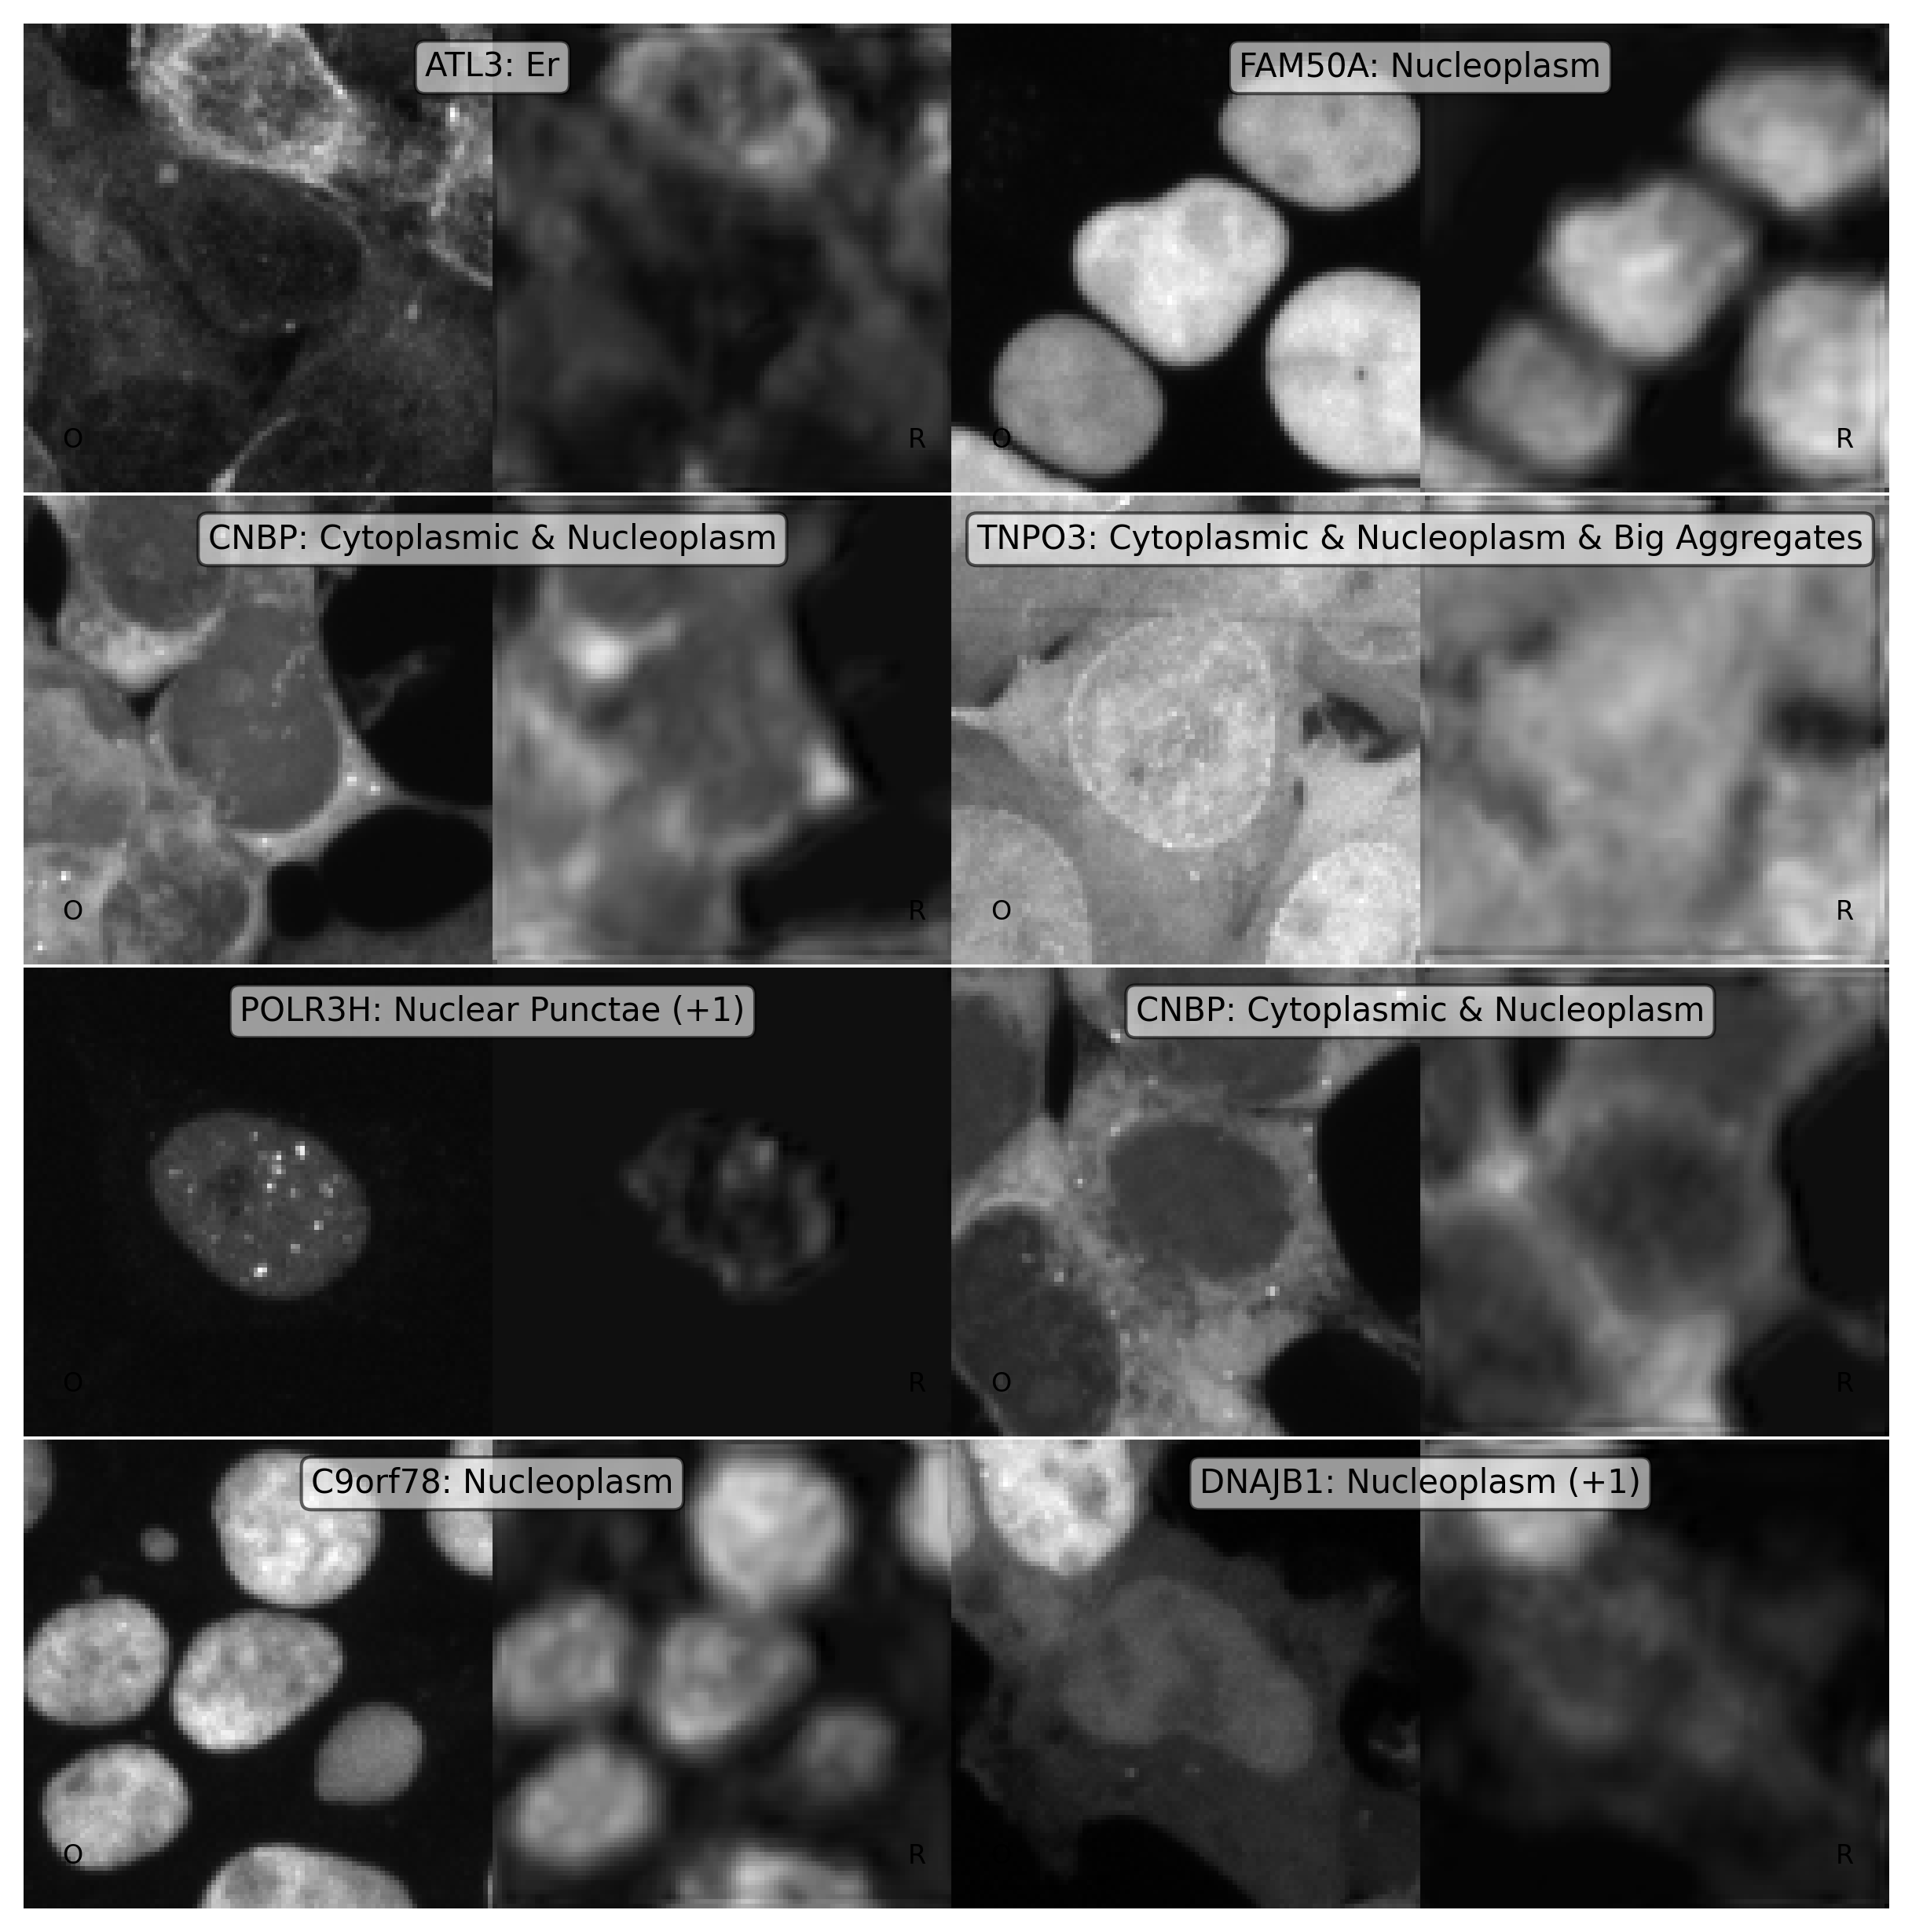

In [5]:
from dlfb.localization.inspect.reconstruction import show_reconstruction

show_reconstruction(dataset_splits["valid"], state, n=8, rng=rng_frames);

### 6.5.2. Evaluation Metrics over Epochs


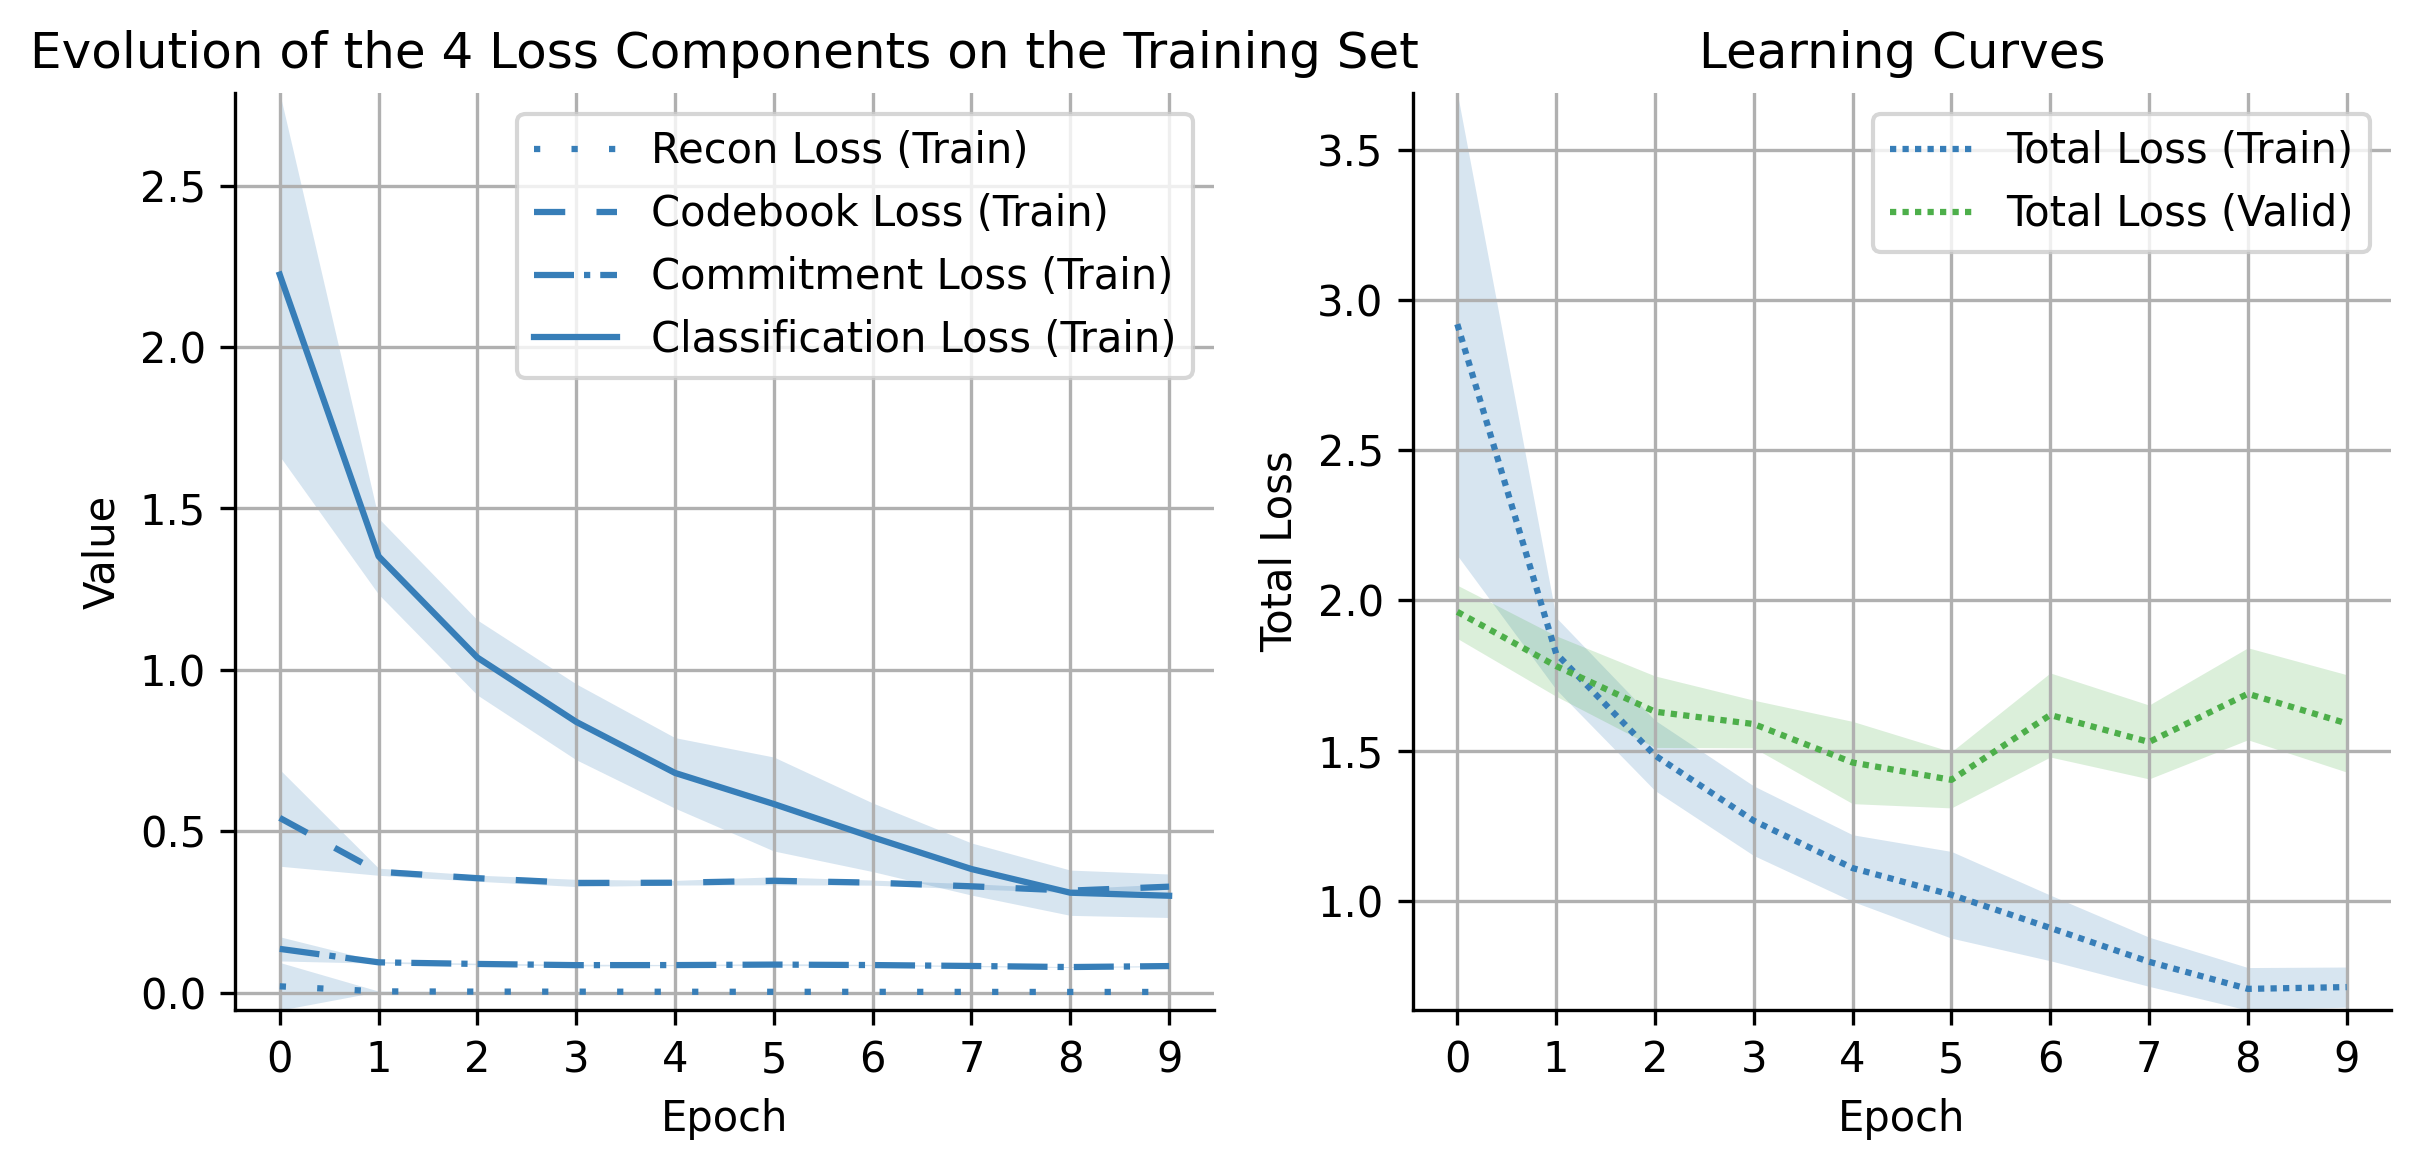

In [6]:
from dlfb.localization.inspect.metrics import plot_losses

plot_losses(metrics);

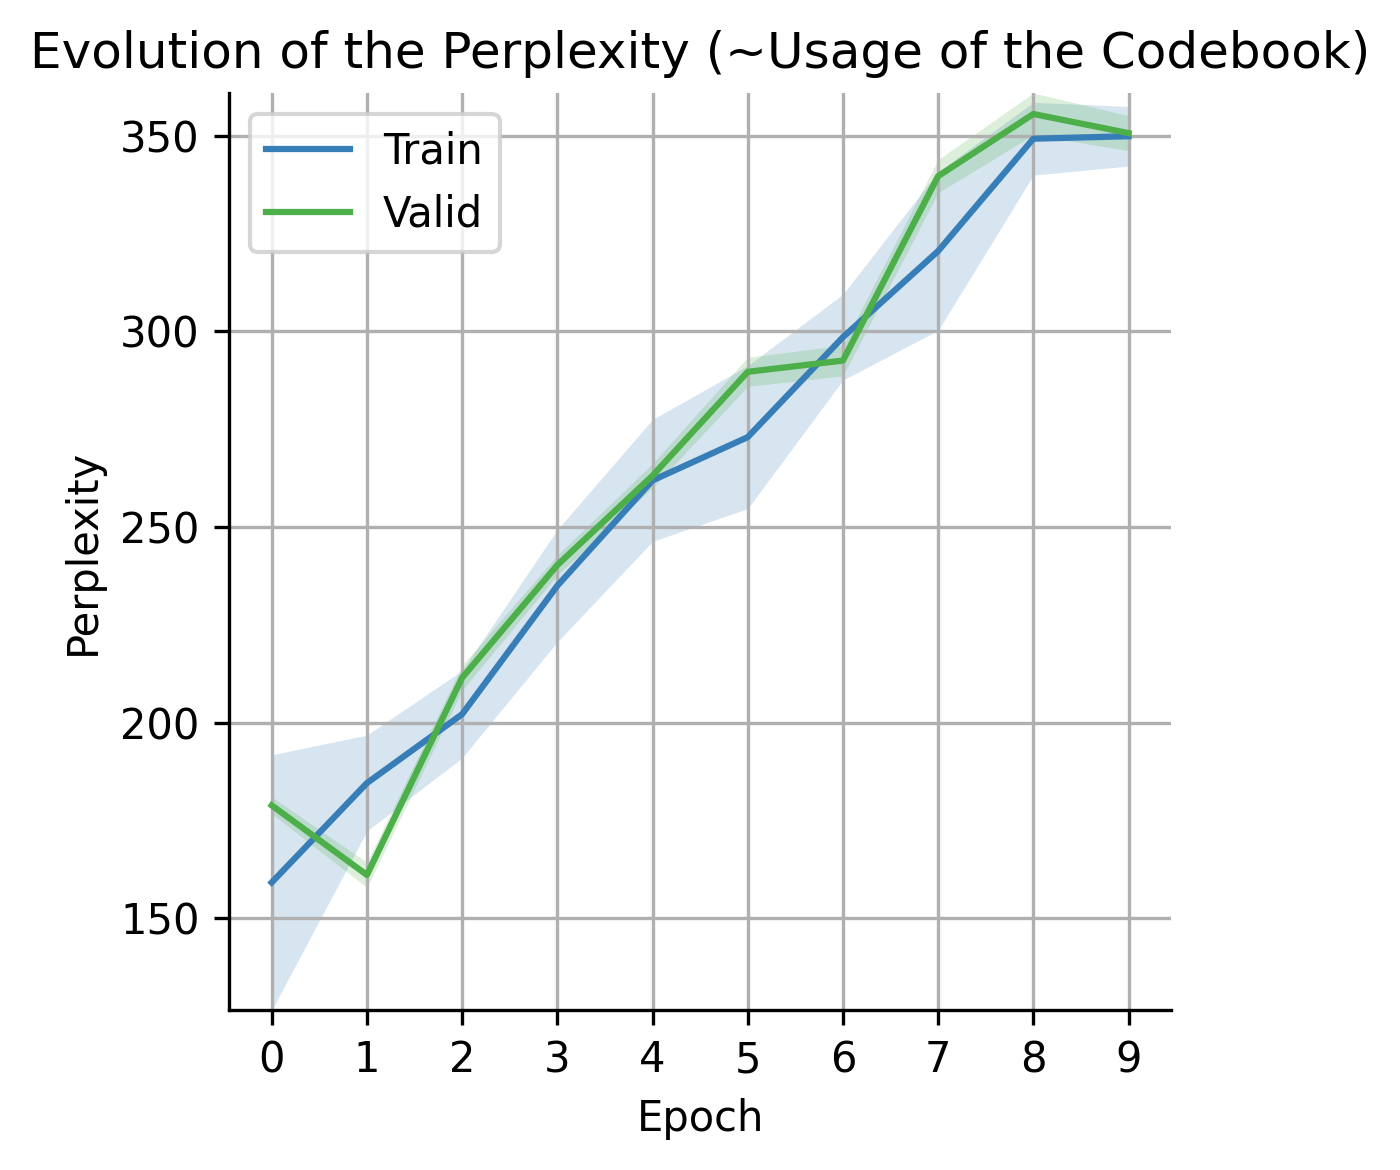

In [7]:
from dlfb.localization.inspect.metrics import plot_perplexity

plot_perplexity(metrics);

### 6.5.3. Model without Classification Task


In [8]:
state_alt, metrics_alt = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=0,  # i.e. the protein id are ignored
  eval_every=1,
  store_path=assets("localization/models/small_alt"),
)

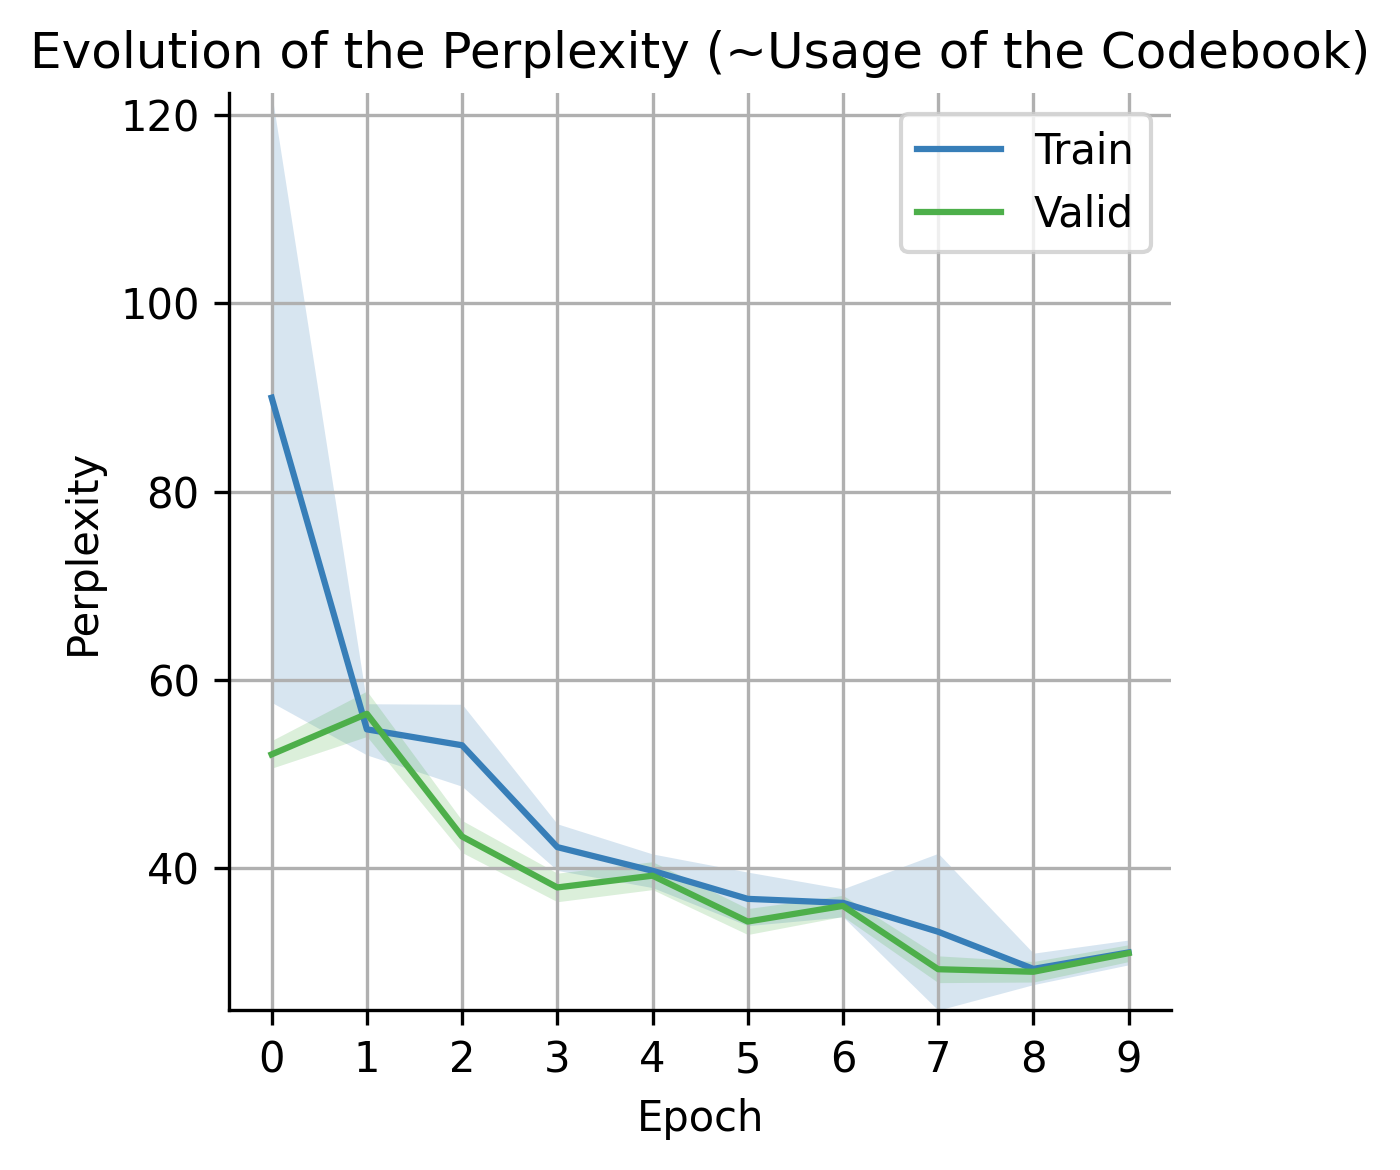

In [9]:
plot_perplexity(metrics_alt);

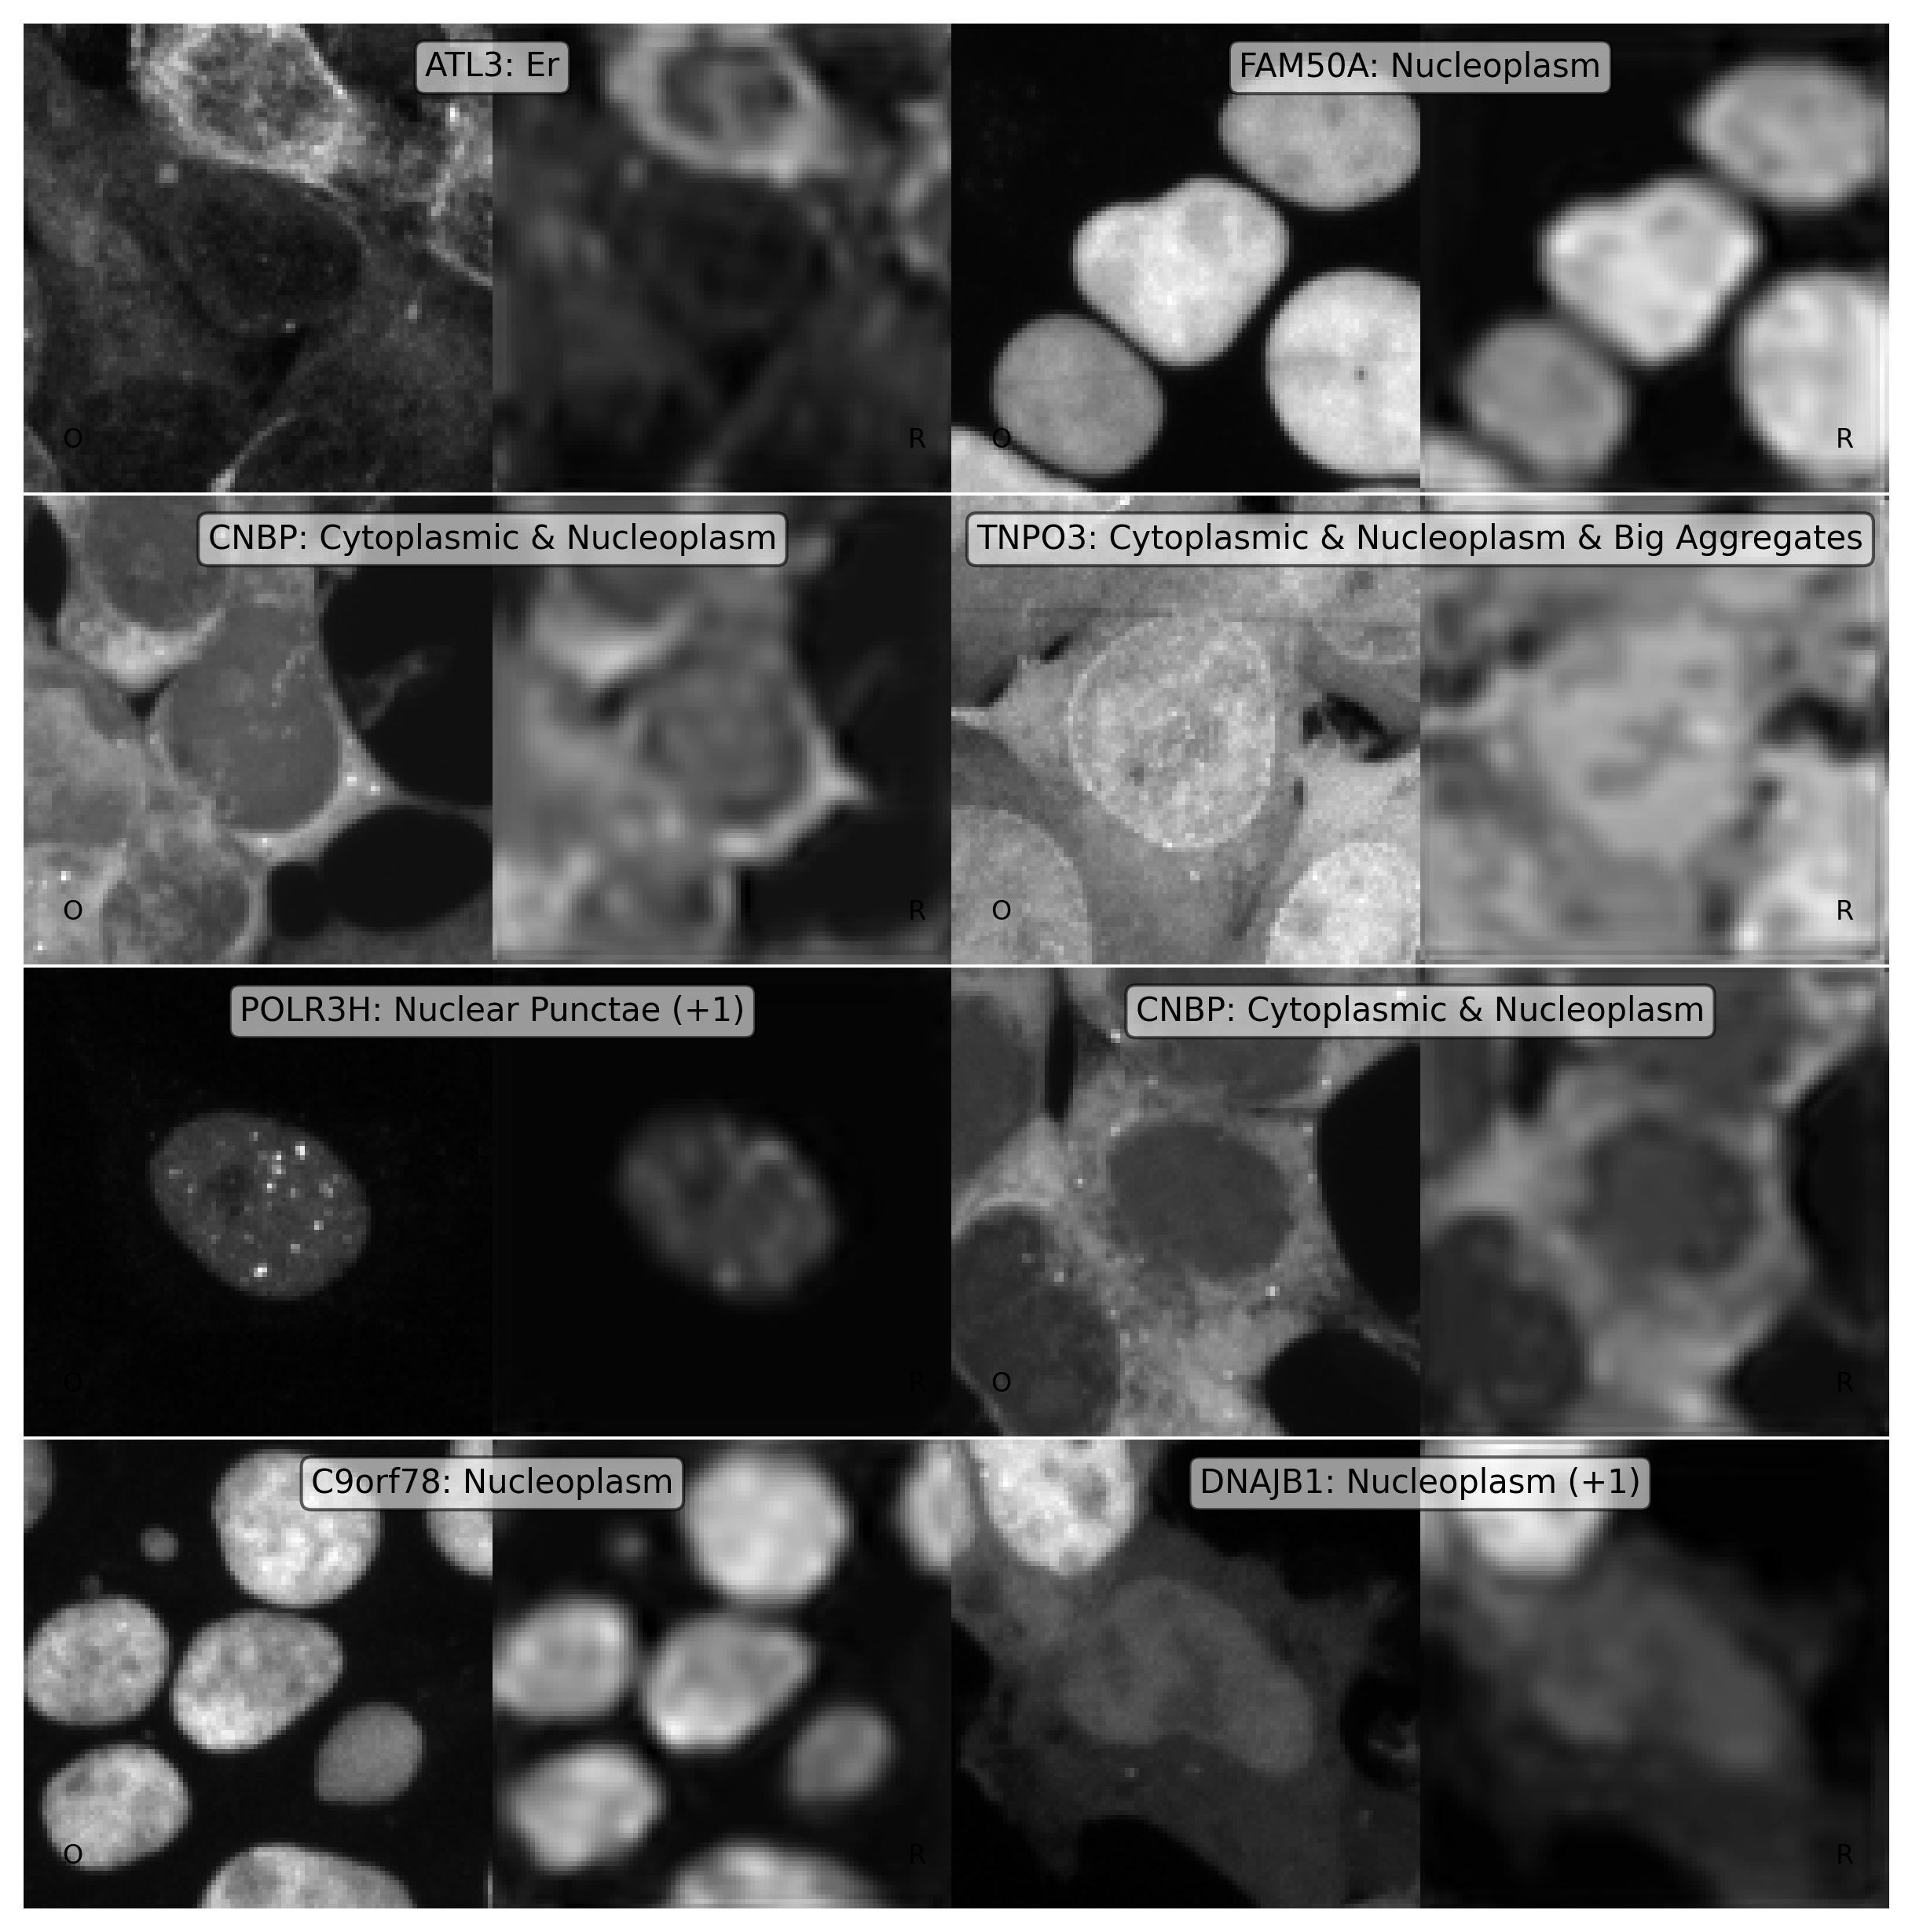

In [10]:
show_reconstruction(dataset_splits["valid"], state_alt, n=8, rng=rng_frames);

## 6.6. Understanding the Model
### 6.6.1. Understanding Localization Clustering


In [3]:
from dlfb.localization.inspect.embeddings.utils import get_frame_embeddings

display([get_frame_embeddings])

def get_frame_embeddings(
  state: TrainState,
  dataset_split: Dataset,
  batch_size: int = 256,
) -> dict[str, np.ndarray]:
  """Returns per-frame histograms of codebook encoding indices."""
  num_embeddings = get_num_embeddings(state)
  frame_ids, frame_histograms = [], []

  rng = jax.random.PRNGKey(42)
  for batch in dataset_split.get_batches(rng, batch_size):
    frame_ids.append(batch["frame_ids"])
    encoding_indices = pluck_encodings(state, batch)

    # Reshape and count codebook usage per frame.
    frame_histograms.append(
      np.apply_along_axis(
        lambda x: np.histogram(x, bins=np.arange(0, num_embeddings + 0.5))[0],
        axis=1,
        arr=jnp.reshape(encoding_indices, (batch_size, -1)),
      )
    )

  return {
    "frame_ids": np.concatenate(frame_ids),
    "frame_histograms": np.concatenate(frame_histograms, axis=0),
  }

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


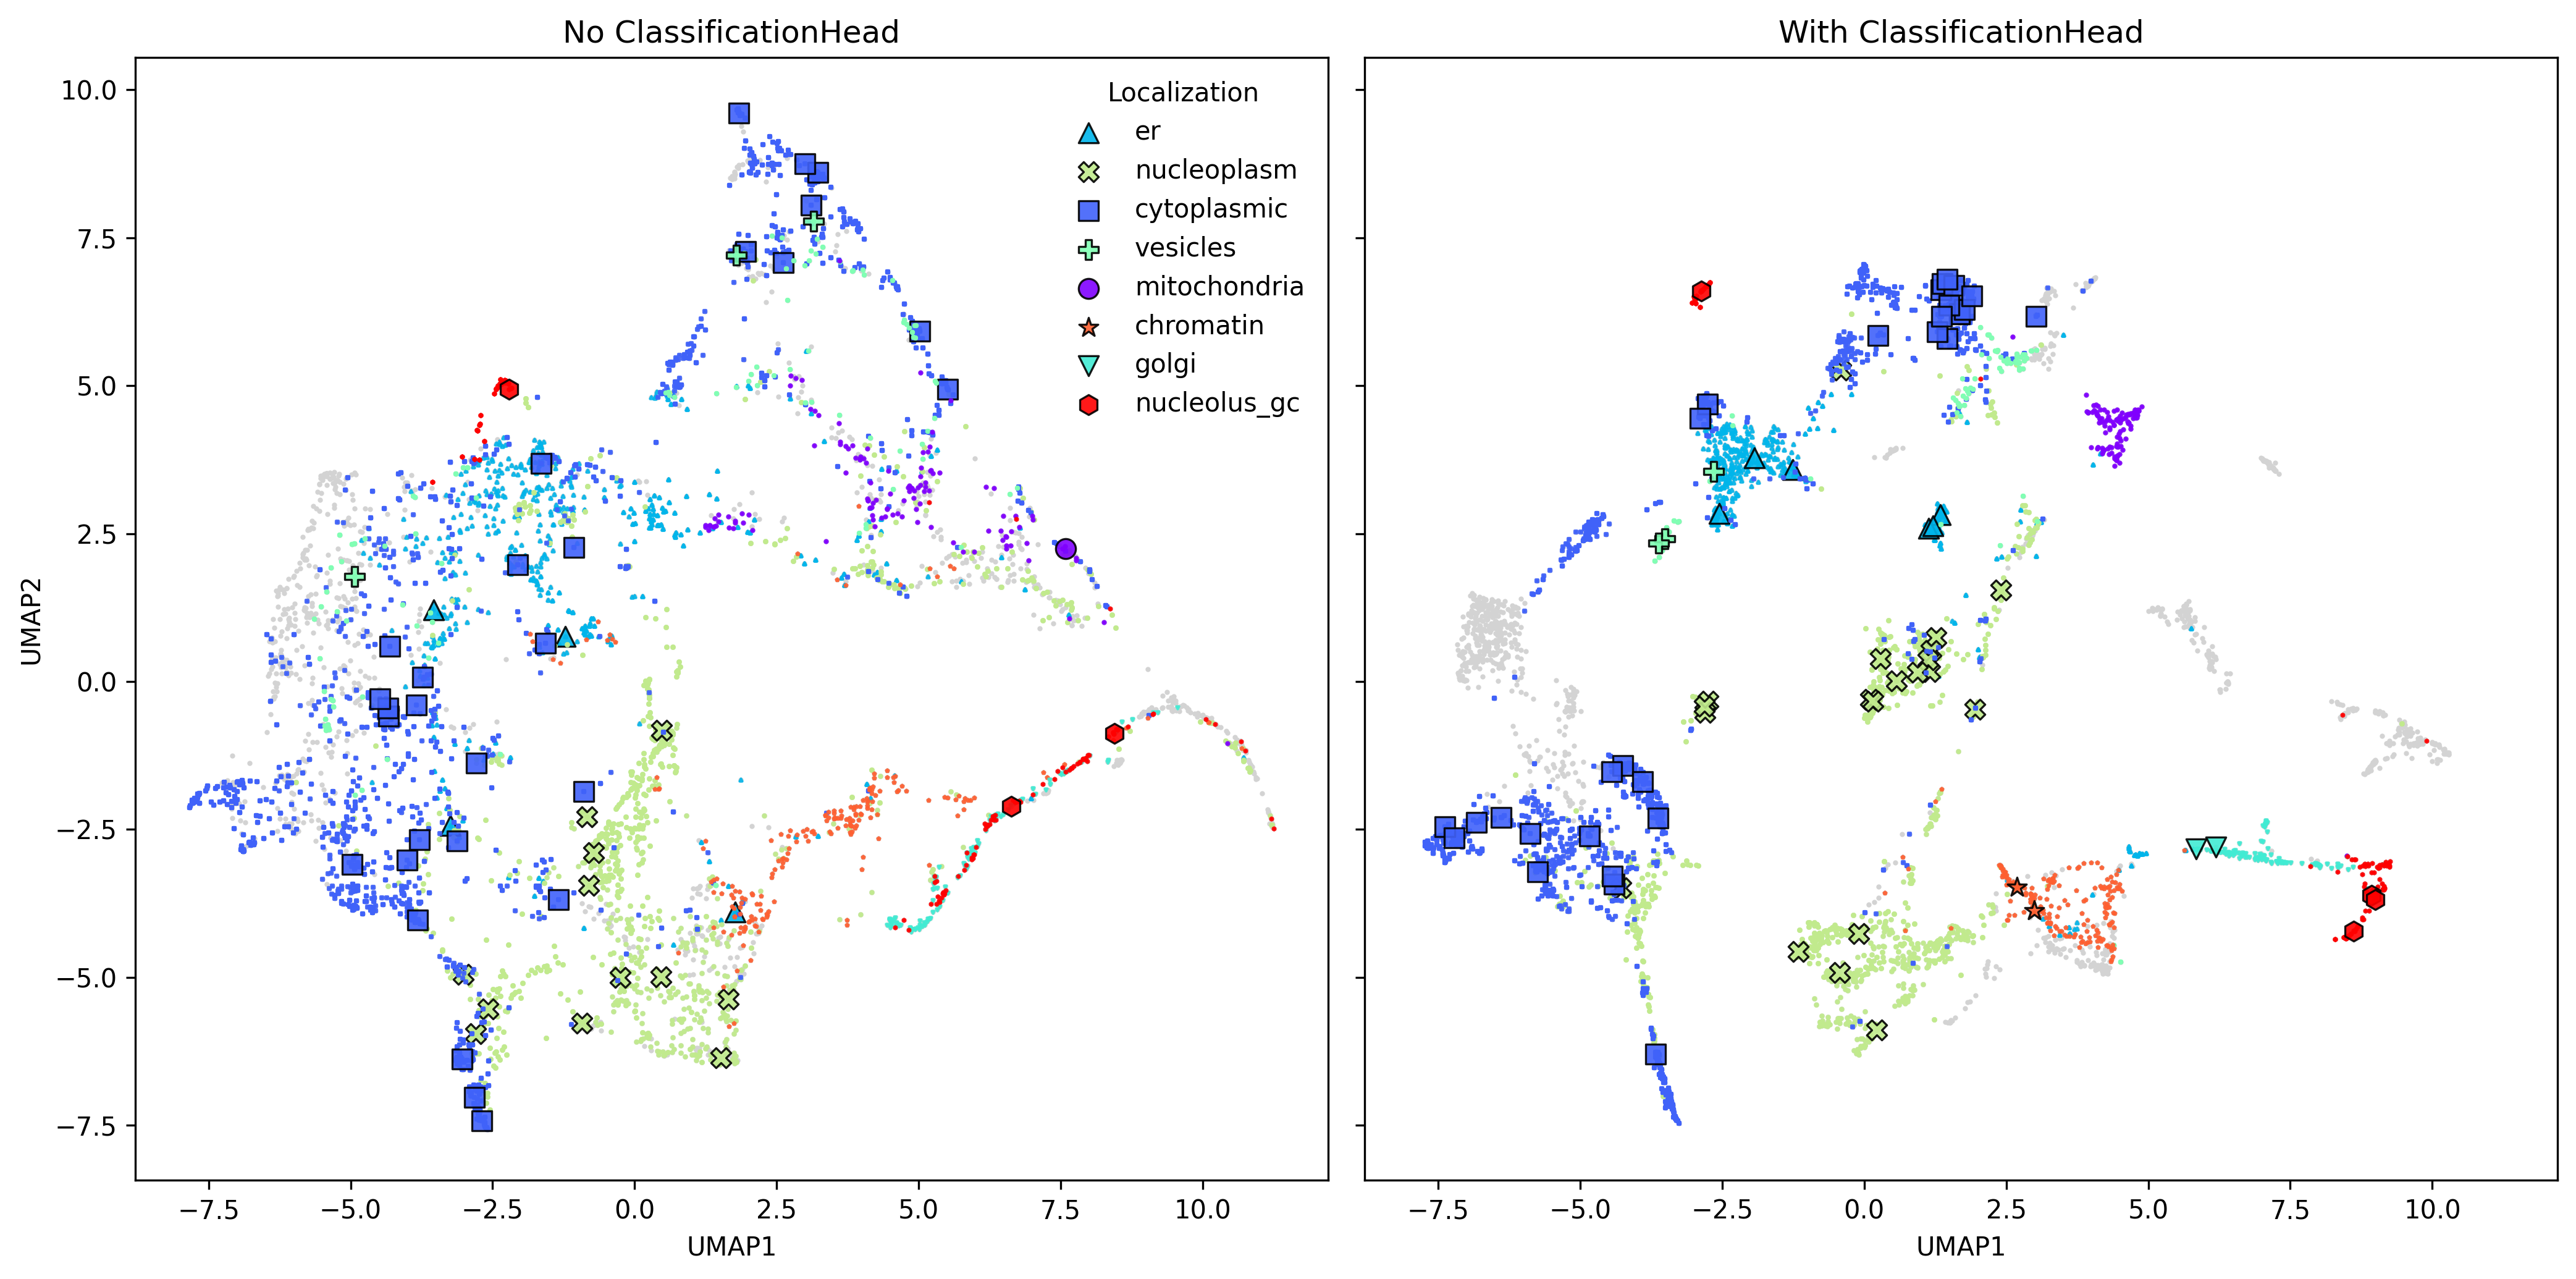

In [4]:
from dlfb.localization.inspect.embeddings.clustering import (
  calculate_projection,
  plot_projection,
)
from dlfb.localization.inspect.embeddings.utils import get_frame_embeddings

frame_embeddings = {}
for name, s in zip(["no_head", "with_head"], [state_alt, state]):
  frame_embeddings[name] = get_frame_embeddings(s, dataset_splits["valid"])

projection = calculate_projection(frame_embeddings)
plot_projection(
  projection,
  dataset_splits["valid"],
  titles=["No ClassificationHead", "With ClassificationHead"],
);

### 6.6.2. Inspecting Feature Spectrums


In [5]:
from dlfb.localization.inspect.embeddings.utils import cluster_feature_spectrums

display([cluster_feature_spectrums])

def cluster_feature_spectrums(
  protein_histograms: np.ndarray, n_clusters: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Cluster proteins based on similarity in codebook usage patterns."""
  corr_idx_idx = np_pearson_cor(protein_histograms, protein_histograms)
  tree = linkage(
    corr_idx_idx,
    method="average",
    metric="euclidean",
    optimal_ordering=True,
  )
  encoding_clusters = fcluster(tree, n_clusters, criterion="maxclust")
  return corr_idx_idx, tree, encoding_clusters

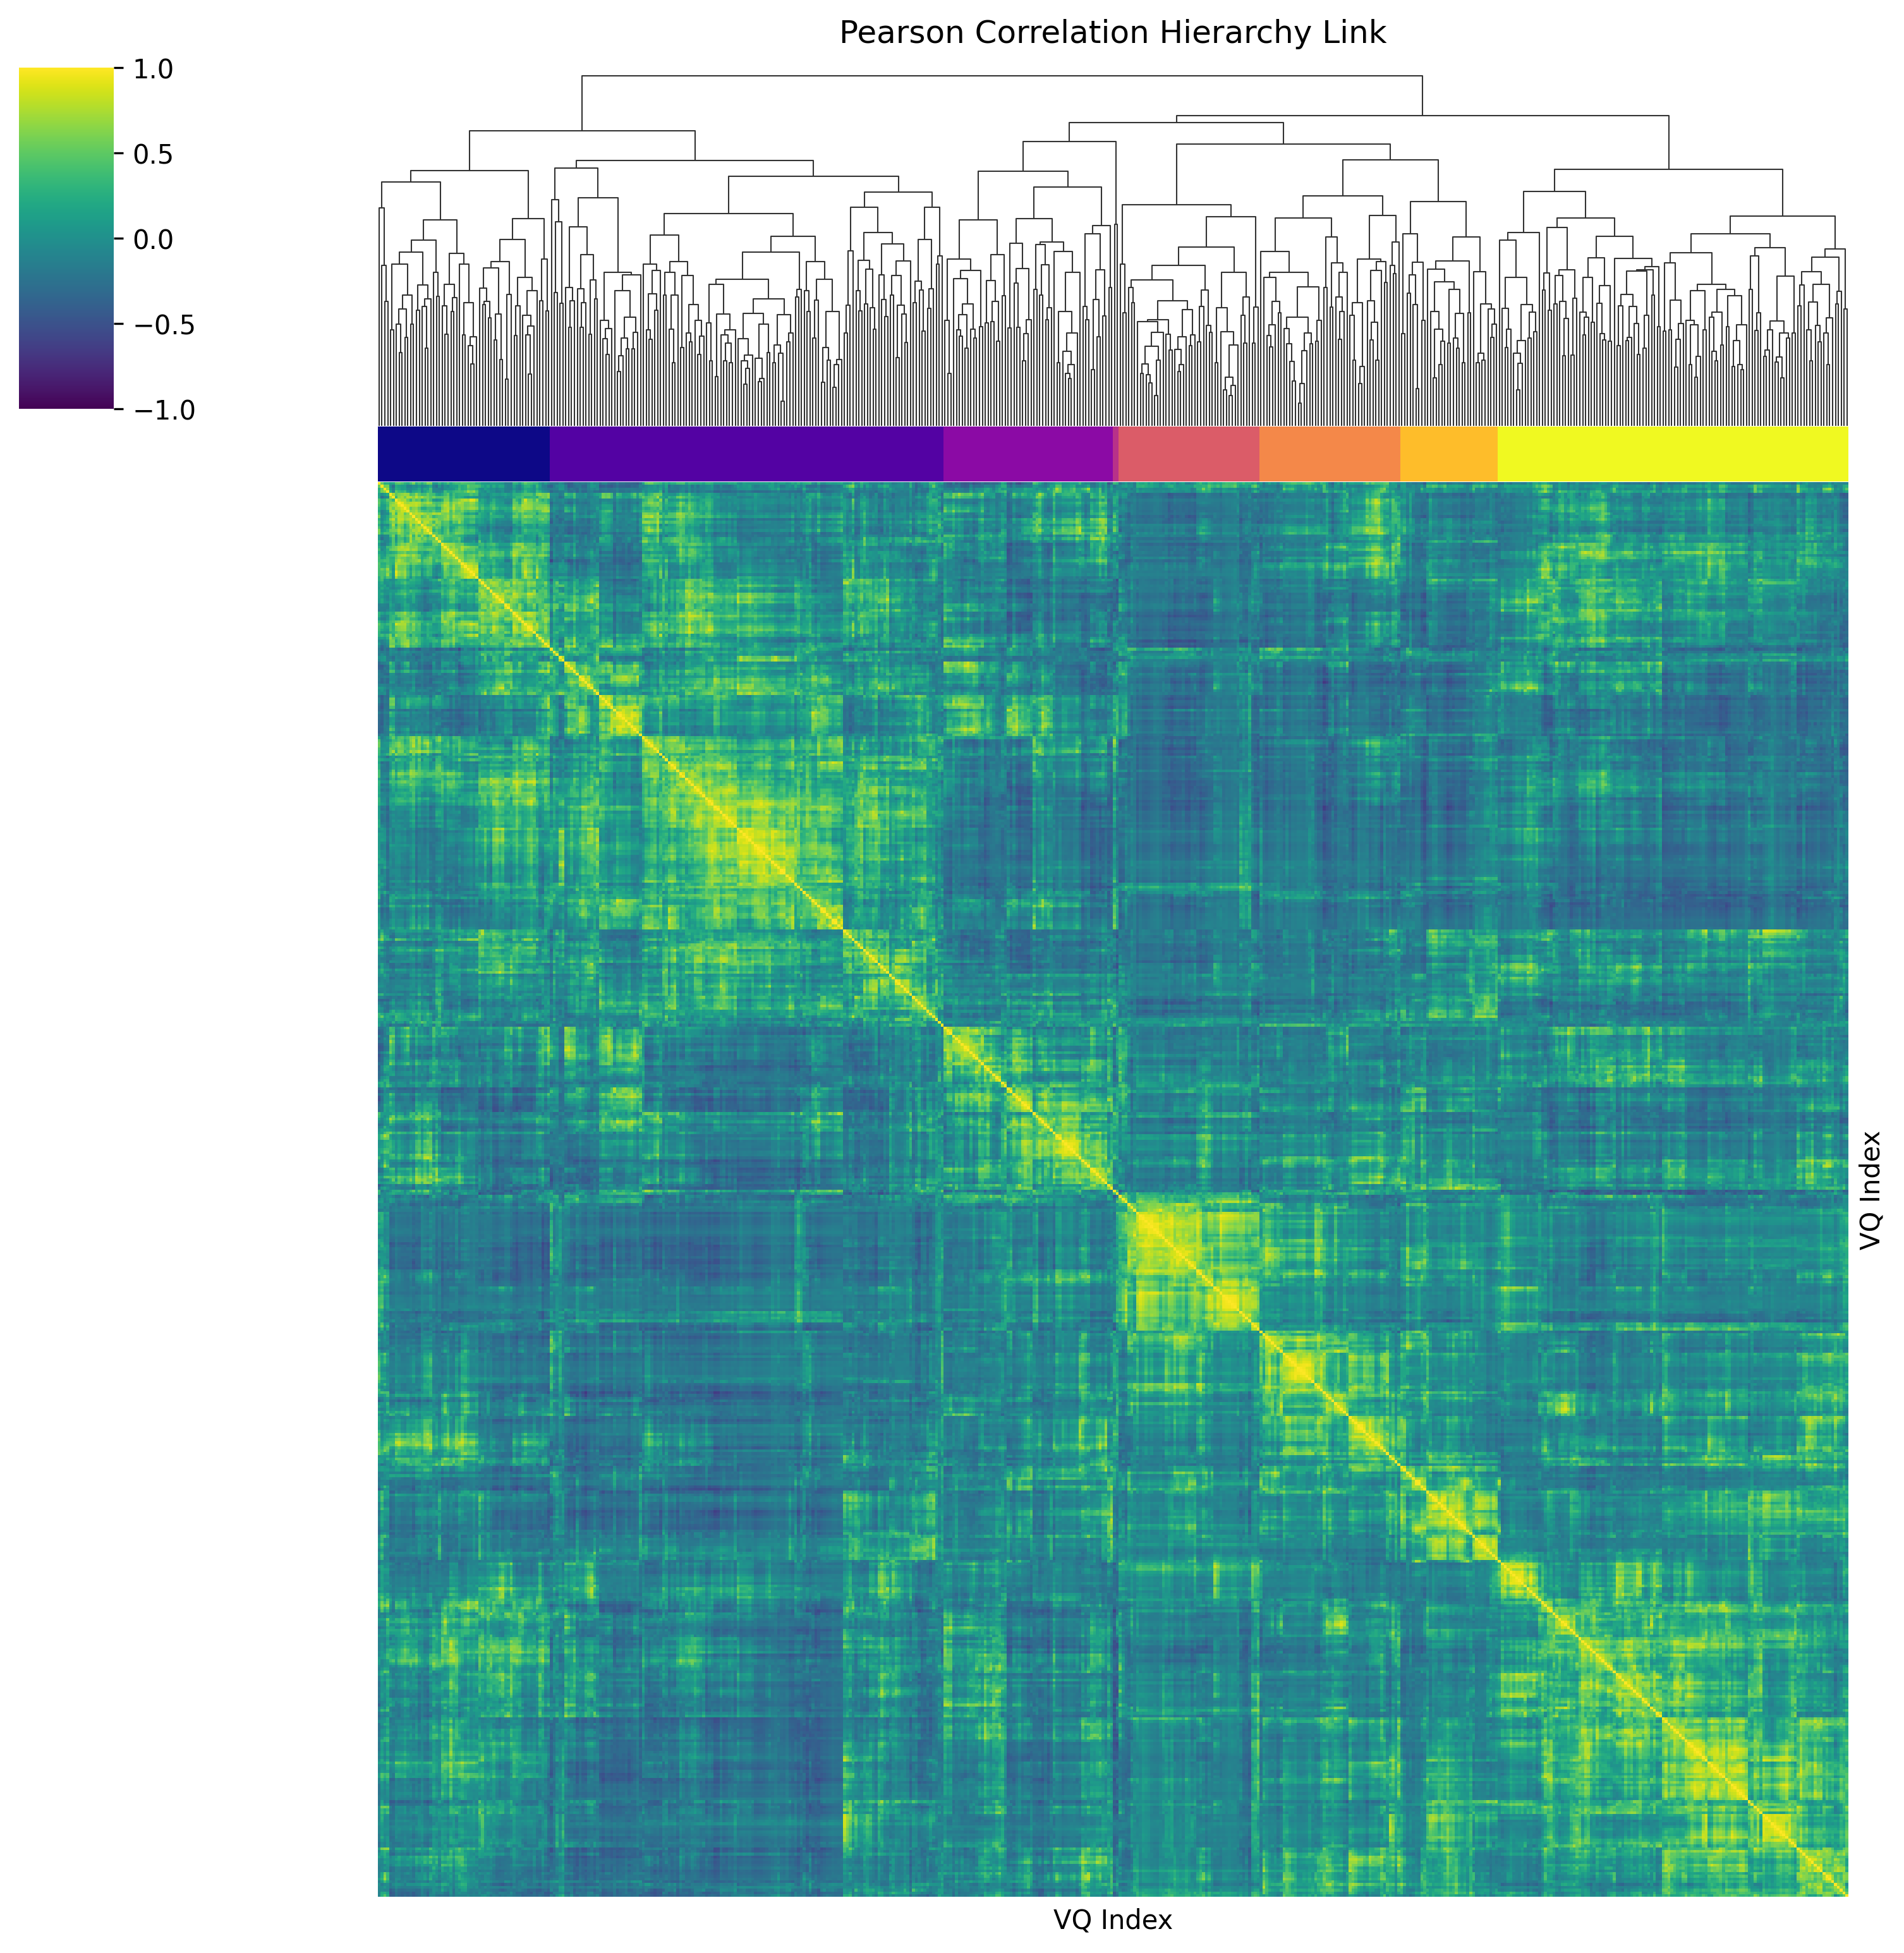

In [6]:
from dlfb.localization.inspect.embeddings.feature_spectrum import (
  plot_encoding_corr_heatmap,
)
from dlfb.localization.inspect.embeddings.utils import aggregate_proteins

protein_ids, protein_histograms = aggregate_proteins(
  dataset_splits["valid"], **frame_embeddings["with_head"]
)
corr_idx_idx, tree, encoding_clusters = cluster_feature_spectrums(
  protein_histograms, n_clusters=8
)
plot_encoding_corr_heatmap(corr_idx_idx, tree, encoding_clusters);

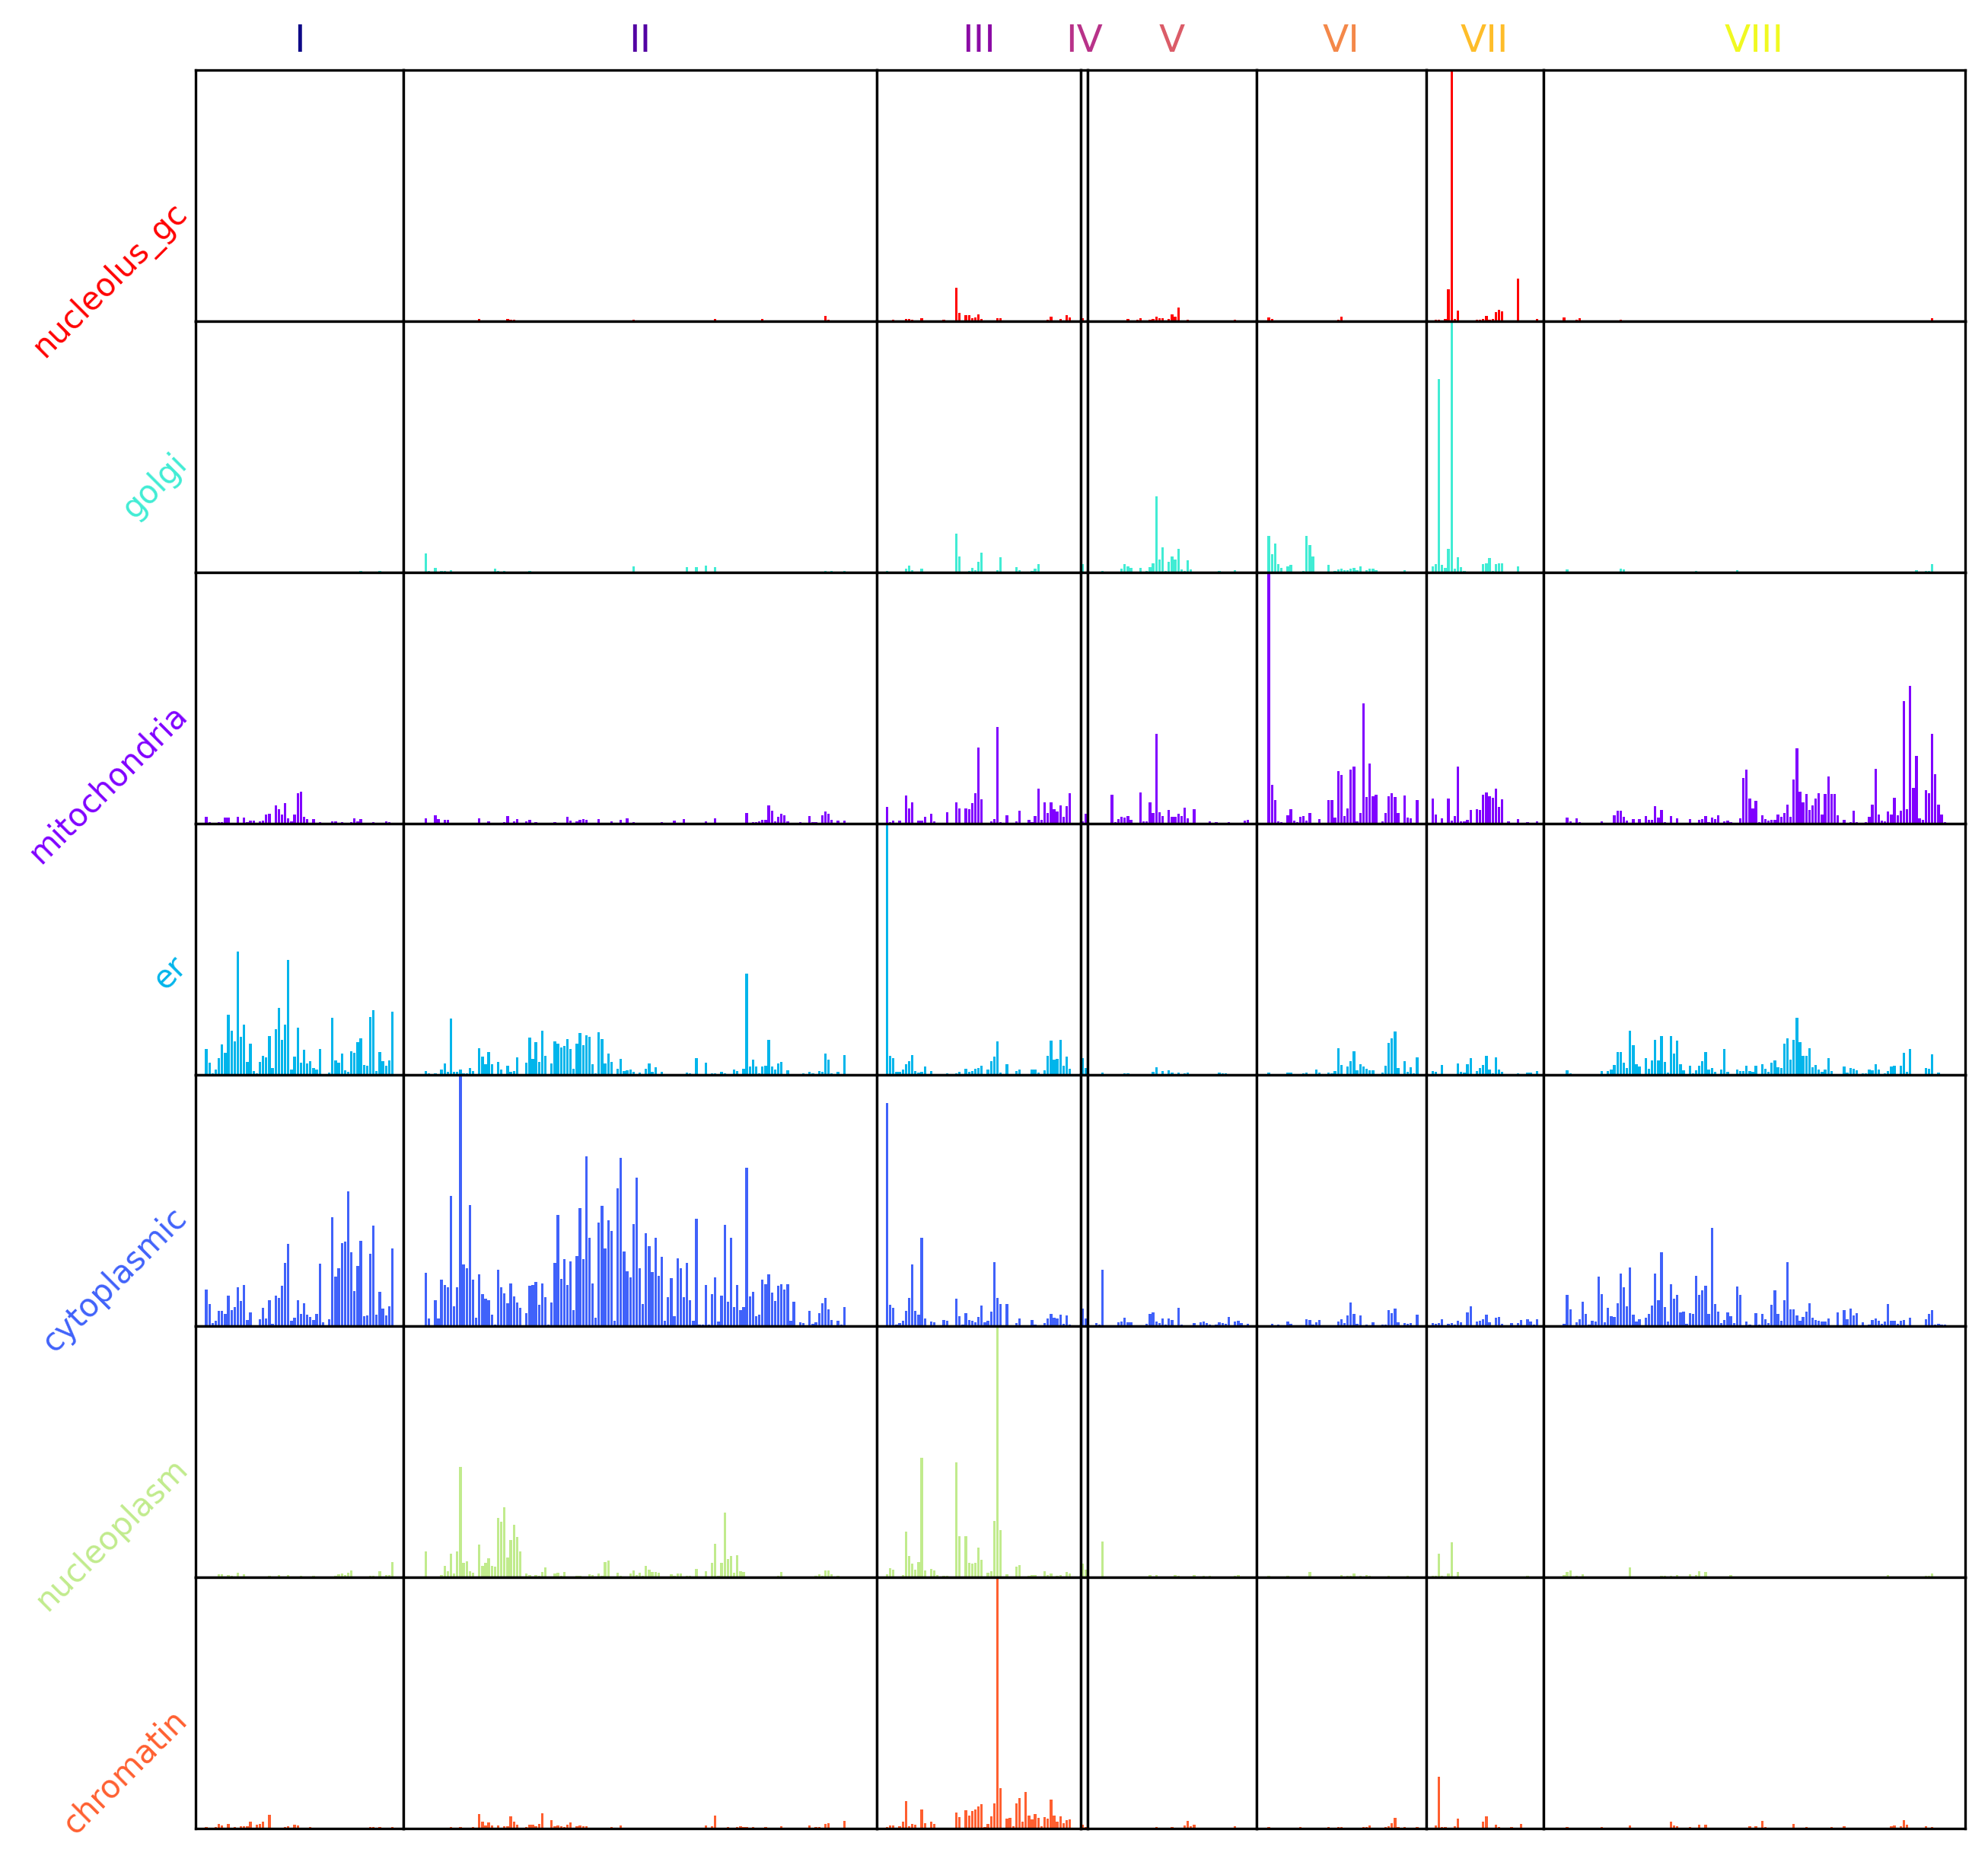

In [7]:
from dlfb.localization.inspect.embeddings.feature_spectrum import (
  plot_stacked_histrograms,
)
from dlfb.localization.inspect.embeddings.utils import aggregate_localizations

localizations, localization_histograms = aggregate_localizations(
  dataset_splits["valid"], protein_ids, protein_histograms
)
plot_stacked_histrograms(
  localizations, localization_histograms, tree, encoding_clusters
);

## 6.7. Improving the Model
### 6.7.1. Scaling Up the Data


In [3]:
dataset_splits = DatasetBuilder(
  data_path=assets("localization/datasets")
).build(
  rng=rng_dataset,
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  n_proteins=500,  # a larger number of proteins
)

model = LocalizationModel(
  num_classes=count_unique_proteins(dataset_splits),
  embedding_dim=64,
  num_embeddings=512,
  commitment_cost=0.25,
  dropout_rate=0.45,
  classification_head_layers=2,
)

state, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=1,
  eval_every=1,
  store_path=assets("localization/models/large"),
)

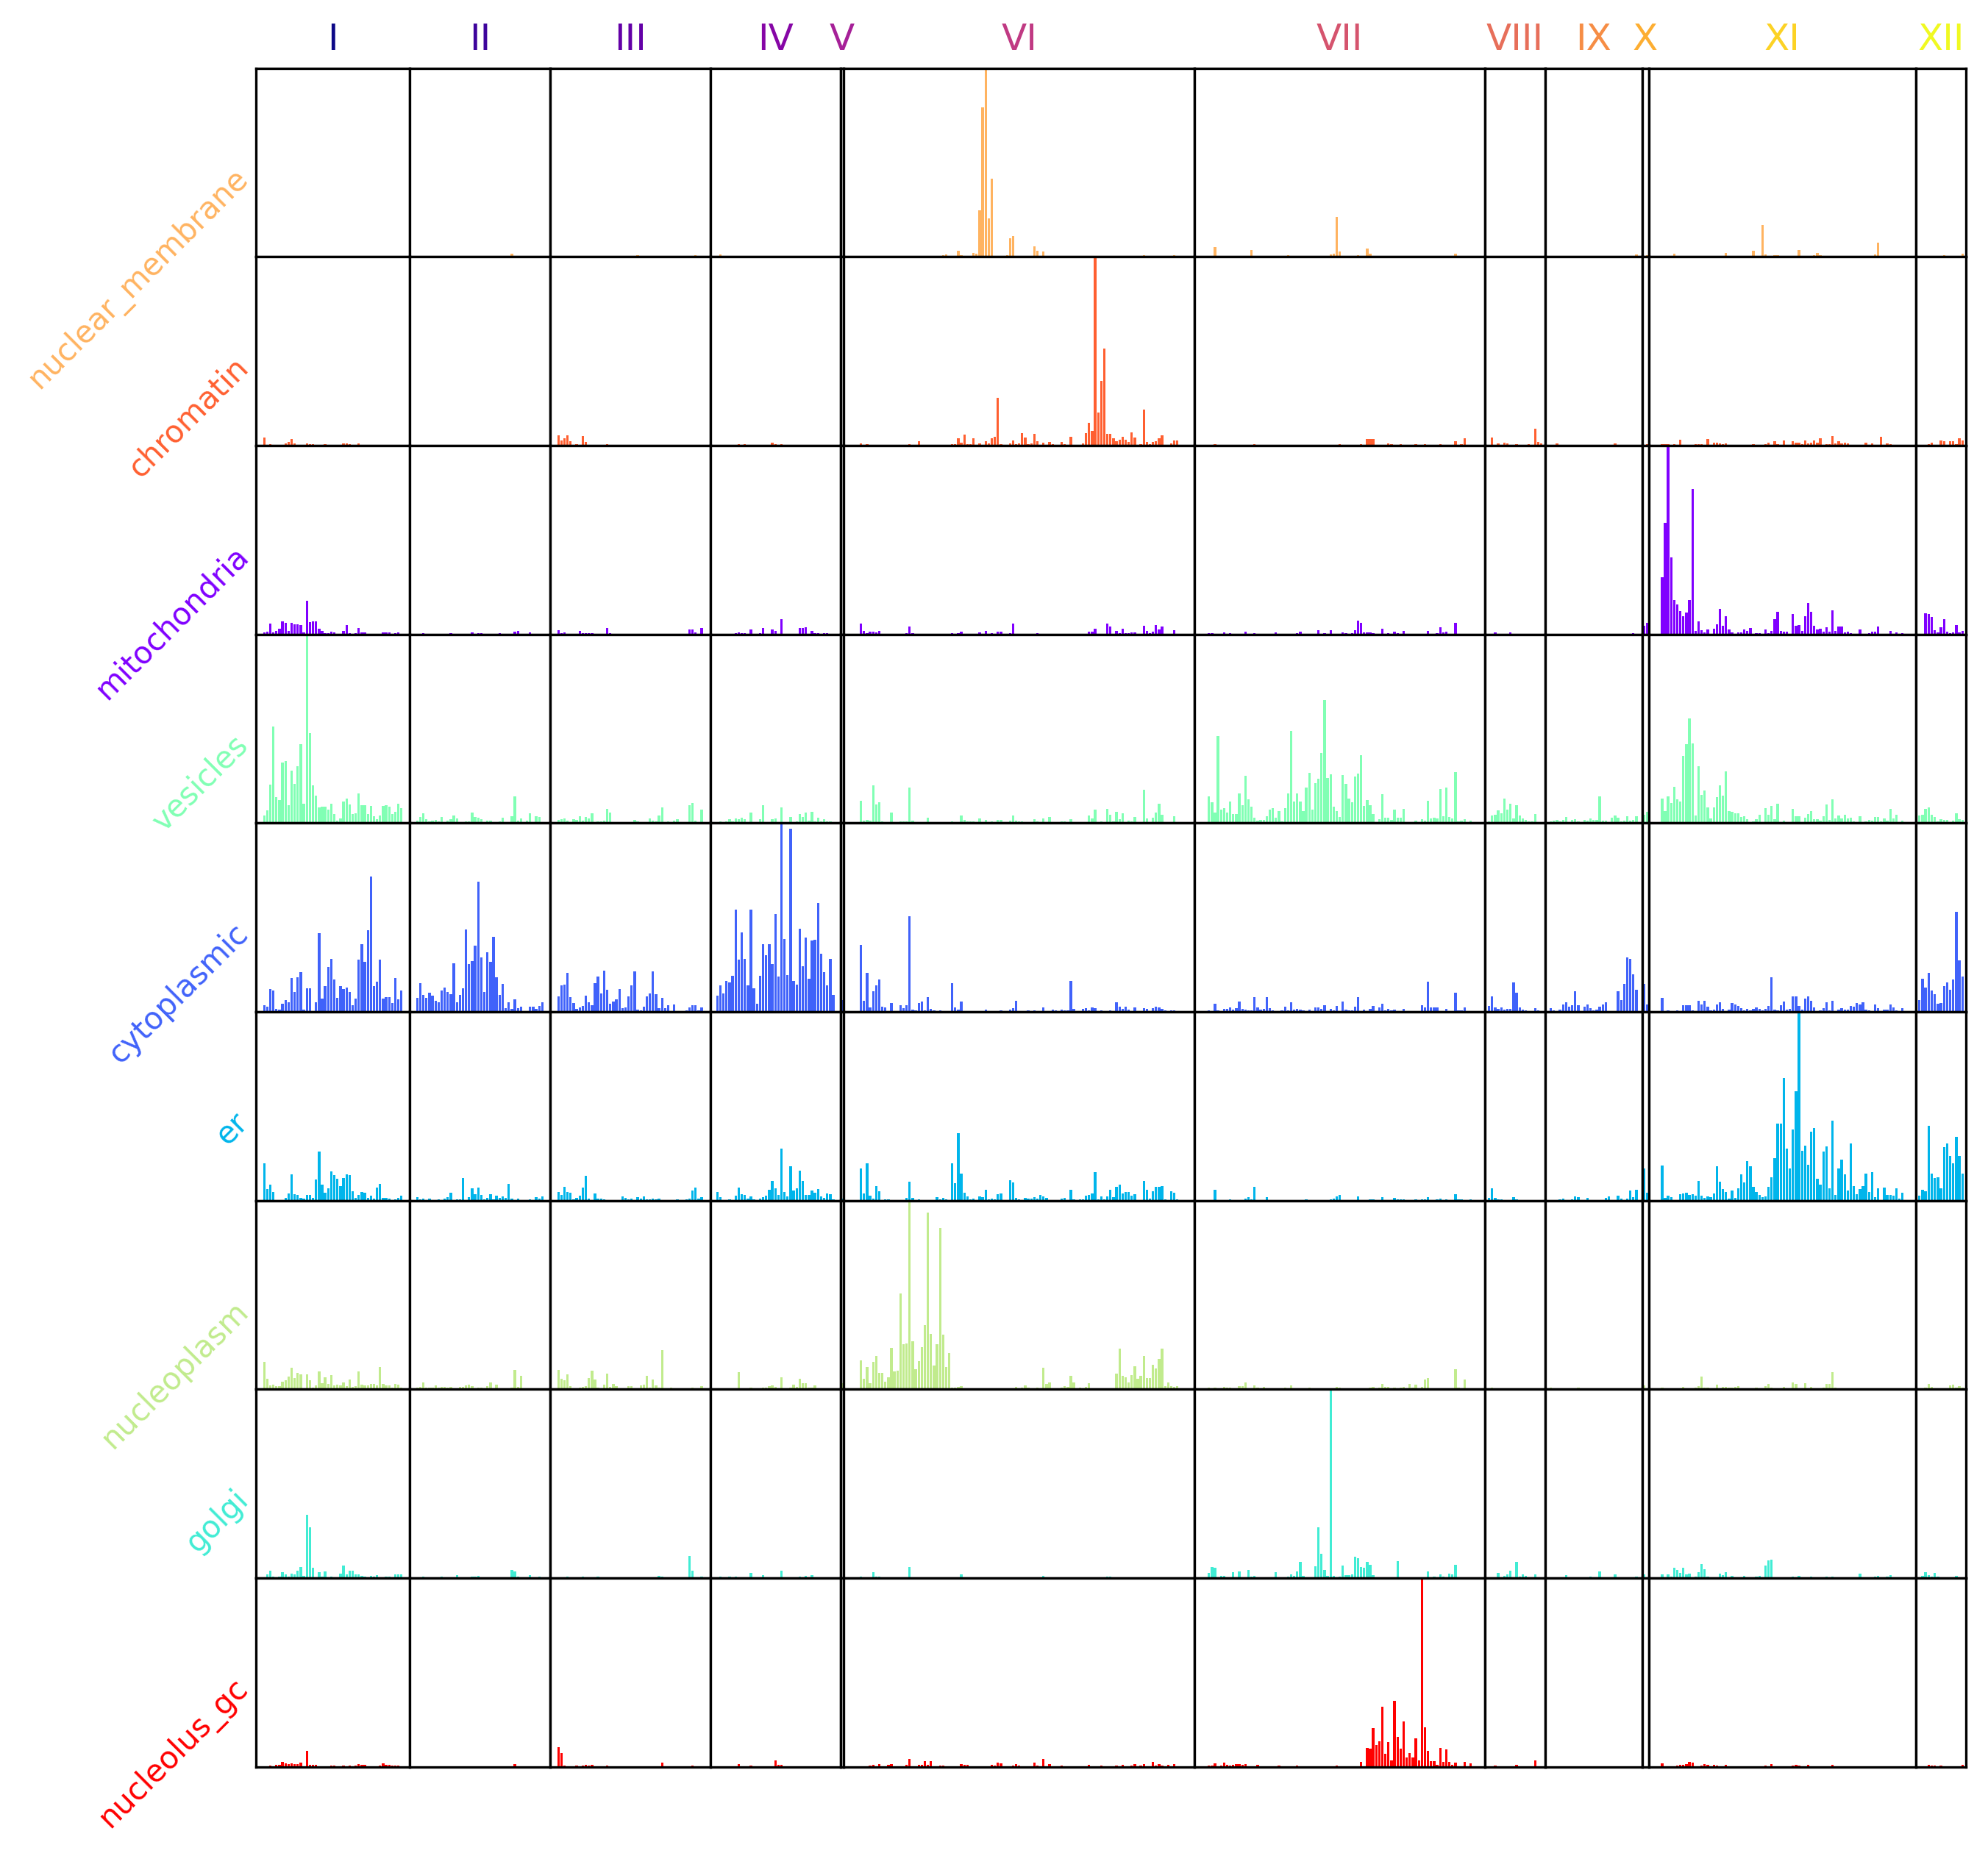

In [4]:
from dlfb.localization.inspect.embeddings.feature_spectrum import (
  plot_stacked_histrograms,
)
from dlfb.localization.inspect.embeddings.utils import (
  aggregate_localizations,
  aggregate_proteins,
  cluster_feature_spectrums,
  get_frame_embeddings,
)

frame_embeddings = get_frame_embeddings(state, dataset_splits["valid"])
protein_ids, protein_histograms = aggregate_proteins(
  dataset_splits["valid"], **frame_embeddings
)
_, tree, encoding_clusters = cluster_feature_spectrums(
  protein_histograms, n_clusters=12
)
localizations, localization_histograms = aggregate_localizations(
  dataset_splits["valid"], protein_ids, protein_histograms
)
plot_stacked_histrograms(
  localizations, localization_histograms, tree, encoding_clusters
);

/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


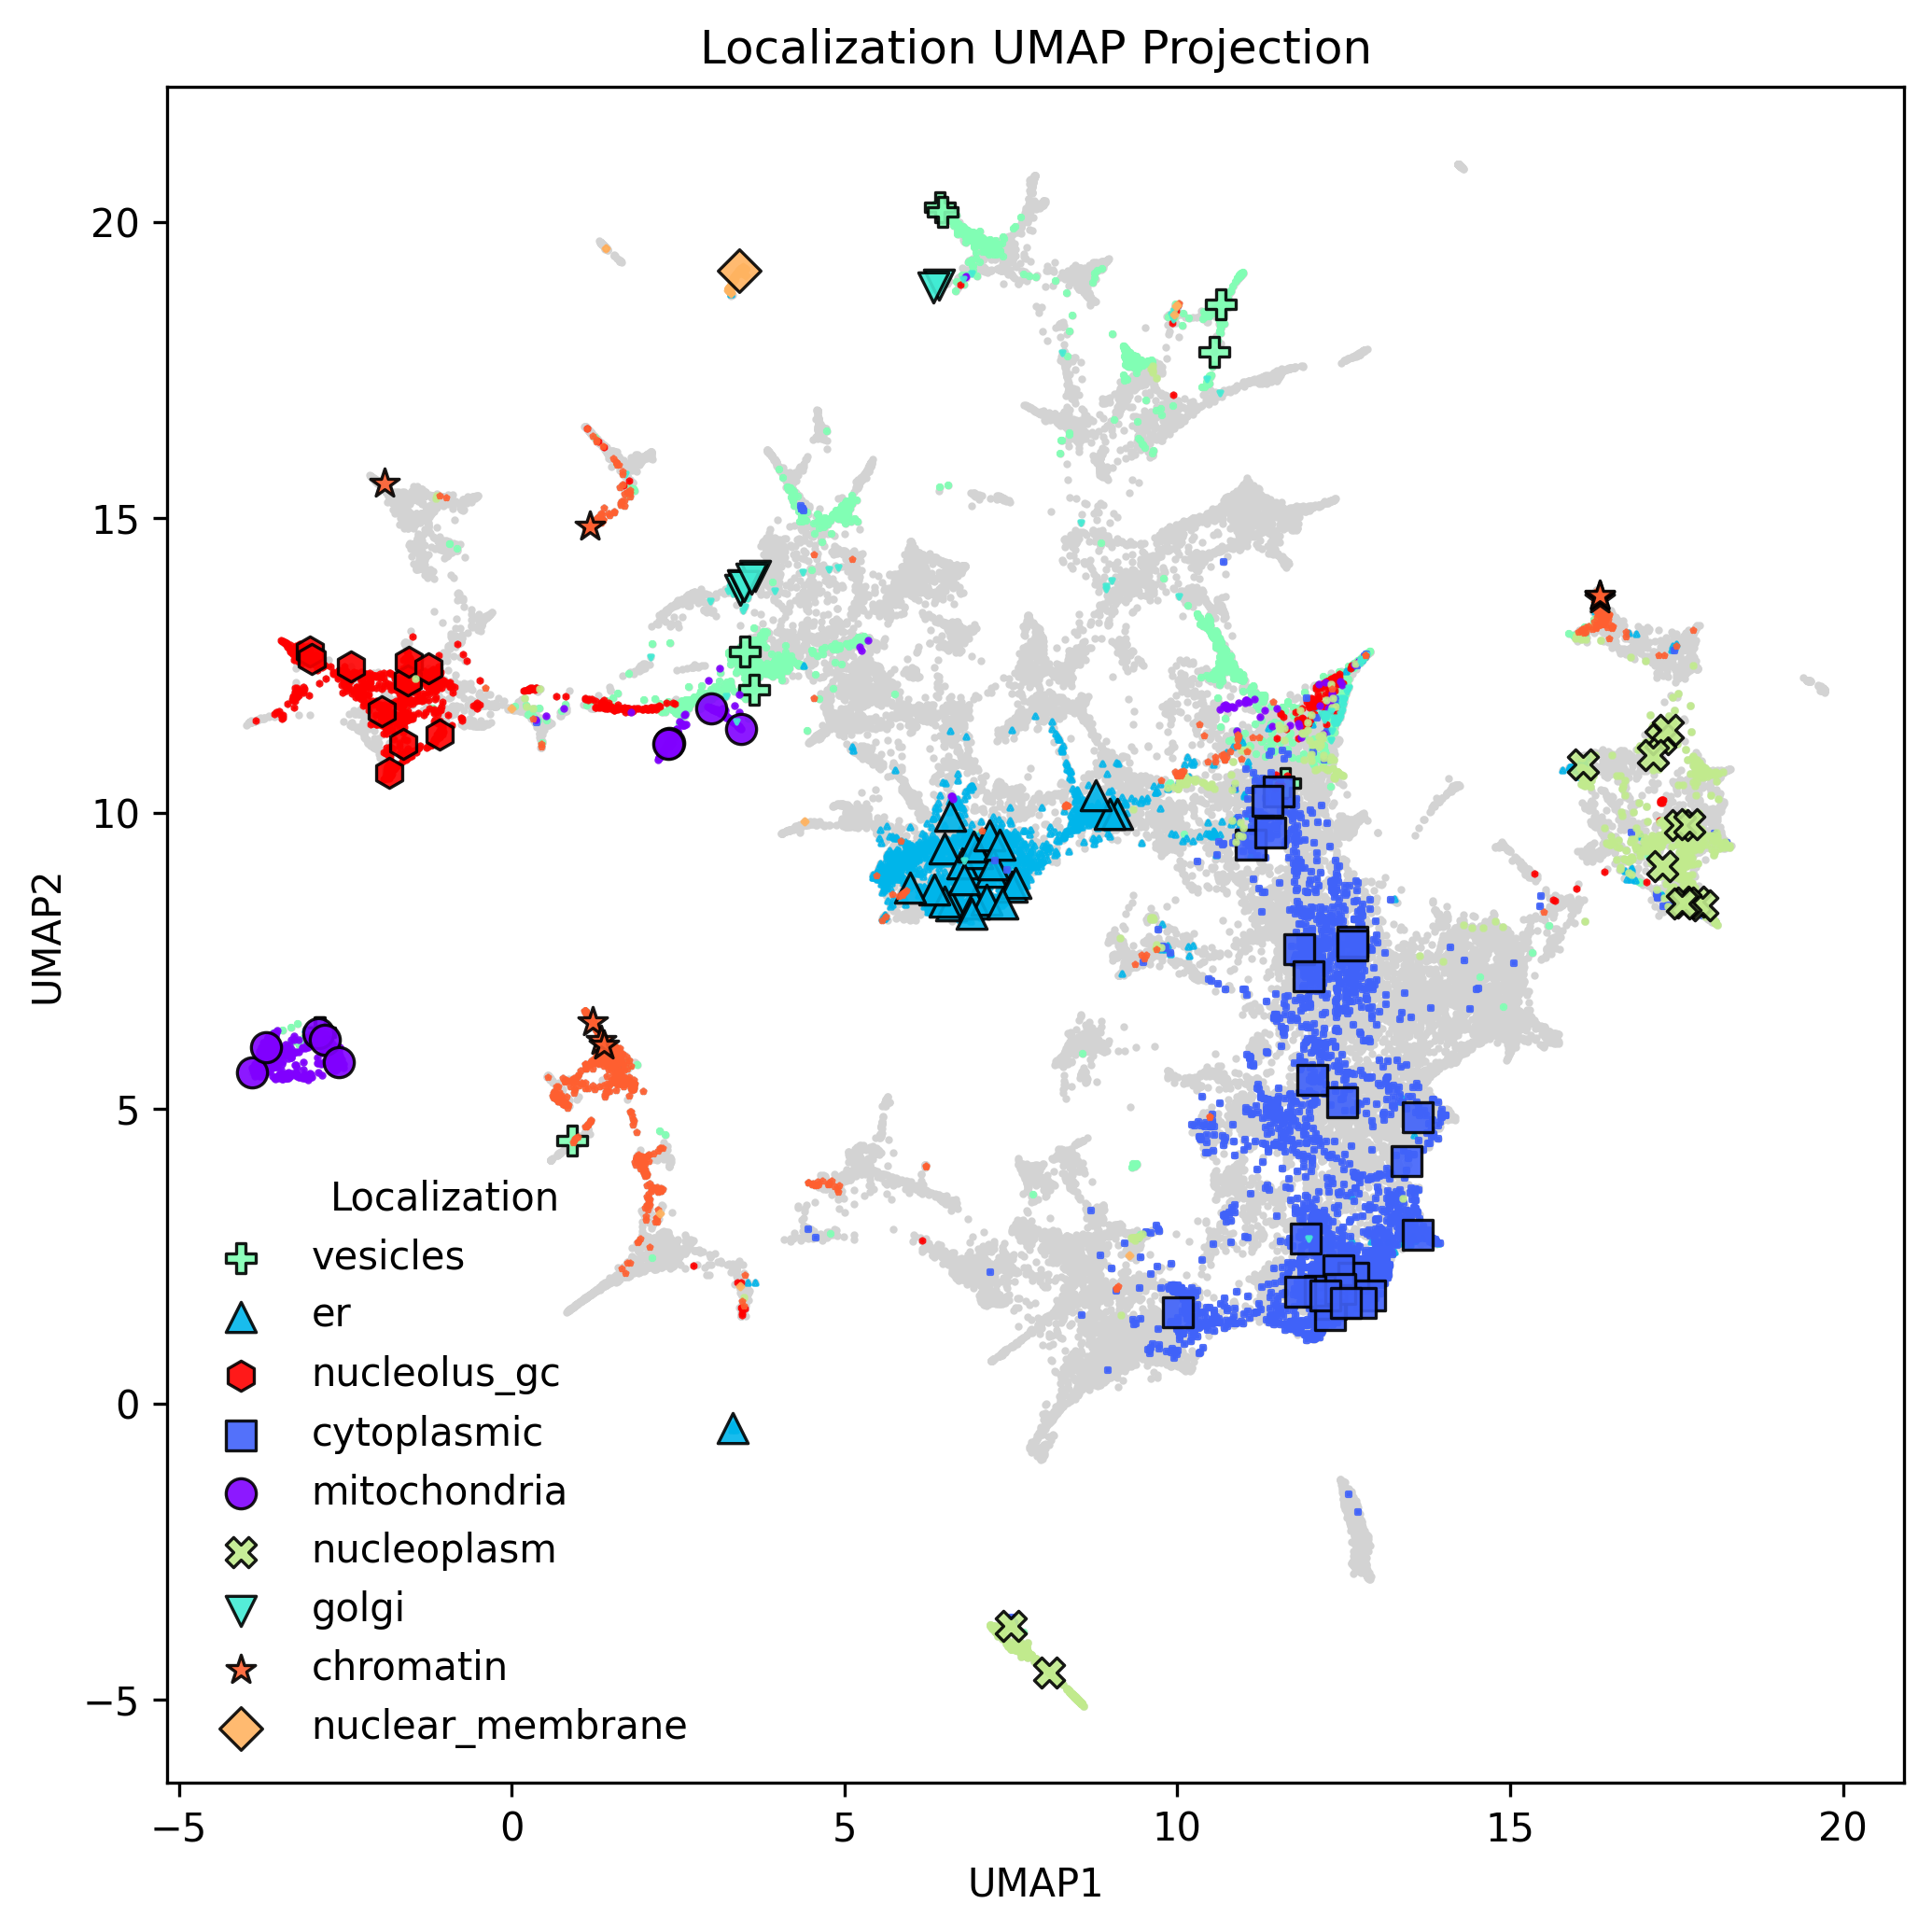

In [5]:
from dlfb.localization.inspect.embeddings.clustering import (
  calculate_projection,
  plot_projection,
)

projection = calculate_projection(frame_embeddings)
plot_projection(
  projection,
  dataset_splits["valid"],
  subset_mode="single",  # Only show frames with single localization
  titles=["Localization UMAP Projection"],
);

### 6.7.2. Going Further


## 6.8. Summary
